# i. Business Understanding

## i.i Blocker Fraud Company

* The Blocker Fraud Company is a company specialized in detecting fraud in financial transactions made through mobile devices. The company has a service called “Blocker Fraud” with no guarantee of blocking fraudulent transactions.

* And the business model of the company is of the Service type with the monetization made by the performance of the service provided, that is, the user pays a fixed fee on the success in detecting fraud in the customer's transactions.

### i.i.i Expansion Problem

Blocker Fraud Company is expanding in Brazil and to acquire customers more quickly, it has adopted a very aggressive strategy. The strategy works as follows:
1. The company will receive 25% of the value of each transaction that is truly detected as fraud.
1. The company will receive 5% of the value of each transaction detected as fraud, but the transaction is truly legitimate.
1. The company will return 100% of the value to the customer, for each transaction detected as legitimate, however the transaction is truly a fraud.

## i.ii The Challenge

You need to deliver to the CEO of Blocker Fraud Company a production model in which your access will be done via API, that is, customers will send their transactions via API so that your model classifies them as fraudulent or legitimate.

### i.ii.i Business Questions

1. What is the model's Precision and Accuracy?
1. How Reliable is the model in classifying transactions as legitimate or fraudulent?
1. What is the Expected Billing by the Company if we classify 100% of transactions with the model?
1. What is the Loss Expected by the Company in case of model failure?
1. What is the Profit Expected by the Blocker Fraud Company when using the model?

# 0.0 Imports and Helper Functions

## 0.1 Imports

In [ ]:
!pip install inflection
!pip install boruta
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 1.2 MB/s eta 0:00:00


In [ ]:
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns

import matplotlib.pyplot as plt

from scipy   import stats
from boruta  import BorutaPy
from category_encoders import OneHotEncoder

from IPython.display      import Image
from IPython.core.display import HTML

from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm          import SVC
from sklearn.dummy        import DummyClassifier
from sklearn.ensemble     import RandomForestClassifier
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics         import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics         import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

## 0.2 Helper Functions

In [ ]:
warnings.filterwarnings('ignore')

seed = 42
np.random.seed(seed)

In [ ]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    sns.set(font_scale=1.6)

    plt.style.use('seaborn-v0_8-darkgrid') # Changed style name
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 16

    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def ml_scores(model_name, y_true, y_pred):

    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3),
                         'Precision': np.round(precision, 3),
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)},
                        index=[model_name])

In [ ]:
def calcCramerV(x, y):
    # Handle empty Series or Series with only one unique value
    if x.empty or y.empty or x.nunique() <= 1 or y.nunique() <= 1:
        return 0.0

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    if n == 0: # Handle case with no data
        return 0.0

    # Ensure cm is at least 2x2 for chi2_contingency
    # If it's 1xN or Nx1, Cramer's V is 0 as there's no association to measure
    if r < 2 or k < 2:
        return 0.0

    try:
        chi2 = float(stats.chi2_contingency(cm)[0])
    except ValueError:
        # This can happen if there are zero-sum rows/columns after crosstab
        return 0.0

    denominator = float(n - 1)
    if denominator == 0:
        chi2corr = 0.0
    else:
        chi2corr = max(0.0, chi2 - (float(k) - 1.0) * (float(r) - 1.0) / denominator)

    denominator_v = (min(float(k) - 1.0, float(r) - 1.0))
    if denominator_v == 0.0:
        return 0.0
    else:
        return np.sqrt(float(chi2corr) / (float(n) * float(denominator_v)))

In [ ]:
def ml_cv_results(model_name, model, x, y, verbose=1):

    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []

    mm = MinMaxScaler()

    x_ = x.to_numpy()
    y_ = y.to_numpy()

    count = 0

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))

        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]

        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)

        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))


    '''results'''
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)

    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

# 1.0 Data Description

## 1.1 Loading Data

In [ ]:
df1 = pd.read_csv('/content/fraud_0.1origbase.csv')

In [ ]:
df1.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,283,CASH_IN,210329.84,C1159819632,3778062.79,3988392.64,C1218876138,1519266.60,1308936.76,0,0
1,132,CASH_OUT,215489.19,C1372369468,21518.00,0.00,C467105520,6345756.55,6794954.89,0,0
2,355,DEBIT,4431.05,C1059822709,20674.00,16242.95,C76588246,80876.56,85307.61,0,0
3,135,CASH_OUT,214026.20,C1464960643,46909.73,0.00,C1059379810,13467450.36,13681476.56,0,0
4,381,CASH_OUT,8858.45,C831134427,0.00,0.00,C579876929,1667180.58,1676039.03,0,0


In [ ]:
df1.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
636257,351,CASH_OUT,28761.10,C742050657,0.0,0.00,C568407561,328534.52,357295.62,0,0
636258,184,CASH_OUT,167820.71,C561181412,62265.0,0.00,C1852953580,106429.48,274250.18,0,0
636259,35,PAYMENT,8898.12,C1773417333,30808.0,21909.88,M445701551,0.00,0.00,0,0
636260,277,CASH_OUT,176147.90,C1423233247,83669.0,0.00,C1328739120,0.00,176147.90,0,0
636261,304,CASH_OUT,95142.89,C874575079,0.0,0.00,C666451134,431380.07,526522.96,0,0


## 1.2 Columns

### 1.2.1 Column Descriptions

**step:** maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type:** CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount:** amount of the transaction in local currency.

**nameOrig:** customer who started the transaction

**oldbalanceOrg:** initial balance before the transaction

**newbalanceOrig:** new balance after the transaction

**nameDest:** customer who is the recipient of the transaction

**oldbalanceDest:** initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest:** new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud:** This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud:** The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

### 1.2.2 Column Rename

In [ ]:
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

In [ ]:
df1.columns

Index(['step', 'type', 'amount', 'name_orig', 'oldbalance_org',
       'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest',
       'is_fraud', 'is_flagged_fraud'],
      dtype='object')

## 1.3 Data Dimension

In [ ]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 636262
Number of Cols: 11


## 1.4 Data Types and Structure

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636262 entries, 0 to 636261
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   step              636262 non-null  int64  
 1   type              636262 non-null  object 
 2   amount            636262 non-null  float64
 3   name_orig         636262 non-null  object 
 4   oldbalance_org    636262 non-null  float64
 5   newbalance_orig   636262 non-null  float64
 6   name_dest         636262 non-null  object 
 7   oldbalance_dest   636262 non-null  float64
 8   newbalance_dest   636262 non-null  float64
 9   is_fraud          636262 non-null  int64  
 10  is_flagged_fraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 53.4+ MB


## 1.5 Check NA

In [ ]:
df1.isna().mean()

,0
step,0.0
type,0.0
amount,0.0
name_orig,0.0
oldbalance_org,0.0
newbalance_orig,0.0
name_dest,0.0
oldbalance_dest,0.0
newbalance_dest,0.0
is_fraud,0.0


## 1.6 Fill Out NA

There's no NaN values to fill.

## 1.7 Change Data Type

 I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [ ]:
df1['is_fraud'] = df1['is_fraud'].map({1: 'yes', 0: 'no'})
df1['is_flagged_fraud'] = df1['is_flagged_fraud'].map({1: 'yes', 0: 'no'})

## 1.8 Description Statistics

In [ ]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.8.1 Numerical Attributes

In [ ]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
step,636262.0,2.429319e+02,1.423309e+02,1.0,155.000,238.000,3.340000e+02,7.420000e+02,7.410000e+02,0.585888,0.375052,0.324437
amount,636262.0,1.800585e+05,6.069714e+05,0.0,13407.425,74815.770,2.084988e+05,5.722962e+07,5.722962e+07,3.370967,29.577107,1546.661043
oldbalance_org,636262.0,8.317937e+05,2.885636e+06,0.0,0.000,14239.000,1.072998e+05,4.368662e+07,4.368662e+07,3.469173,5.243428,32.766036
newbalance_orig,636262.0,8.528354e+05,2.921296e+06,0.0,0.000,0.000,1.435652e+05,4.367380e+07,4.367380e+07,3.425393,5.173614,31.932547
oldbalance_dest,636262.0,1.096212e+06,3.375389e+06,0.0,0.000,131539.745,9.384820e+05,3.551855e+08,3.551855e+08,3.079138,20.622388,1074.335293
newbalance_dest,636262.0,1.221809e+06,3.656213e+06,0.0,0.000,214712.725,1.109230e+06,3.555534e+08,3.555534e+08,2.992460,19.623903,928.694204


* All the data has a coeficient of variation greater than 25%, therefore they aren't homogeneous.

* The step variable starts from 1 hour to 742 hour (30 days).

* Some variables are higher shap and right skewed.

* 50% of the newbalance_orig is 0. Maybe there are some transfers that don't go to the destination.

* The skew is higher positive, therefore the values may be in less values.

### 1.8.2 Categorical Attributes

In [ ]:
cat_attributes.describe()

,type,name_orig,name_dest,is_fraud,is_flagged_fraud
count,636262,636262,636262,636262,636262
unique,5,636171,457224,2,2
top,CASH_OUT,C975429470,C1023714065,no,no
freq,224216,2,14,635441,636260


* The majority type is cash_out with 2237500.

* There's a lot of variability in name_orig, so it could be hard to use one hot encoding.

* There's less name_orig than name_dest. There's more users sending than receiving, however use one hot encoding will not help.

* There's more fraud than the flagged fraud, it shows that the current method can't recognize fraud efficiently.

# 2.0 Feature Engineering

In [ ]:
df2 = df1.copy()

## 2.1 Mind Map

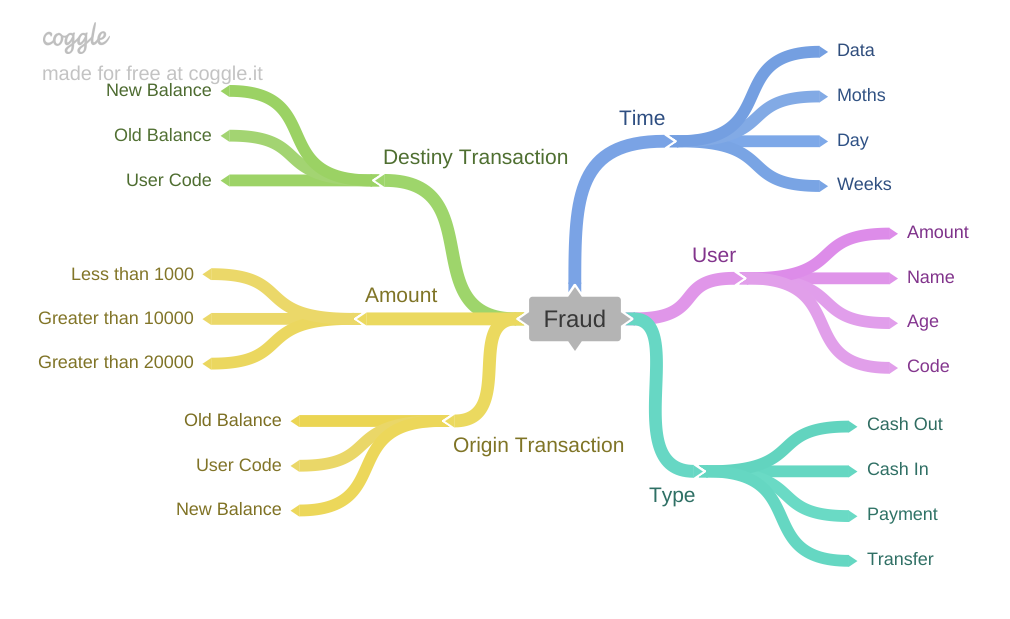

In [ ]:
Image('/content/Fraud-mindmap.png')

## 2.2 Hypothesis Creation

### 2.2.1 User

* 90% of the twentyone-year-old users did a fraud transaction.

* The majority fraud transiction occours for the same initial letter user.

* The fraud amount is greater than 10.000.

* The 60% of the age is greater than 30 year old.

### 2.2.2 Type

* 60% of fraud transaction occours using cash-out-type method.

* The majority transfers occours using tranfers-type method.

* Values greater than 100.000 occours using transfers-type method.

* Payment type occurs with values lower than 100.000

### 2.2.3 Origin and Destiny Transactions

* 60% of the difference between origin destiny transactions is equal 0 for frauds.

* Origin values are greater than destiny values for fraud transaction.

### 2.2.4 Time

* Fraud transactions occours at least in 3 days.

* 40% of the cash-out transactions occours less than 1 day.

* 60% of the transaction less than 100.000 occours at least 10 days.

* The transactions greater than 10.000 occours at most in 2 weeks.

## 2.3 Hipothesys List

1. The majority fraud transiction occours for the same initial letter user.

1. All the fraud amount is greater than 10.000.

1. 60% of fraud transaction occours using cash-out-type method.

1. The majority transfers occours using tranfers-type method.

1. Fraud transactions occours at least in 3 days.

## 2.4 Feature Engineering

In [ ]:
# step
df2['step_days'] = df2['step'].apply(lambda i: i/24)
df2['step_weeks'] = df2['step'].apply(lambda i: i/(24*7))

# difference between initial balance before the transaction and new balance after the transaction
df2['diff_new_old_balance'] = df2['newbalance_orig'] - df2['oldbalance_org']

# difference between initial balance recipient before the transaction and new balance recipient after the transaction.
df2['diff_new_old_destiny'] = df2['newbalance_dest'] - df2['oldbalance_dest']

# name orig and name dest
df2['name_orig'] = df2['name_orig'].apply(lambda i: i[0])
df2['name_dest'] = df2['name_dest'].apply(lambda i: i[0])

# 3.0 Selecting Columns

In [ ]:
df3 = df2.copy()

## 3.1 Selecting Columns

I'll use all the columns for data analysis

## 3.2 Selecting Lines

I'll use all the lines.

# 4.0 Exploratory Data Analisys

In [ ]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

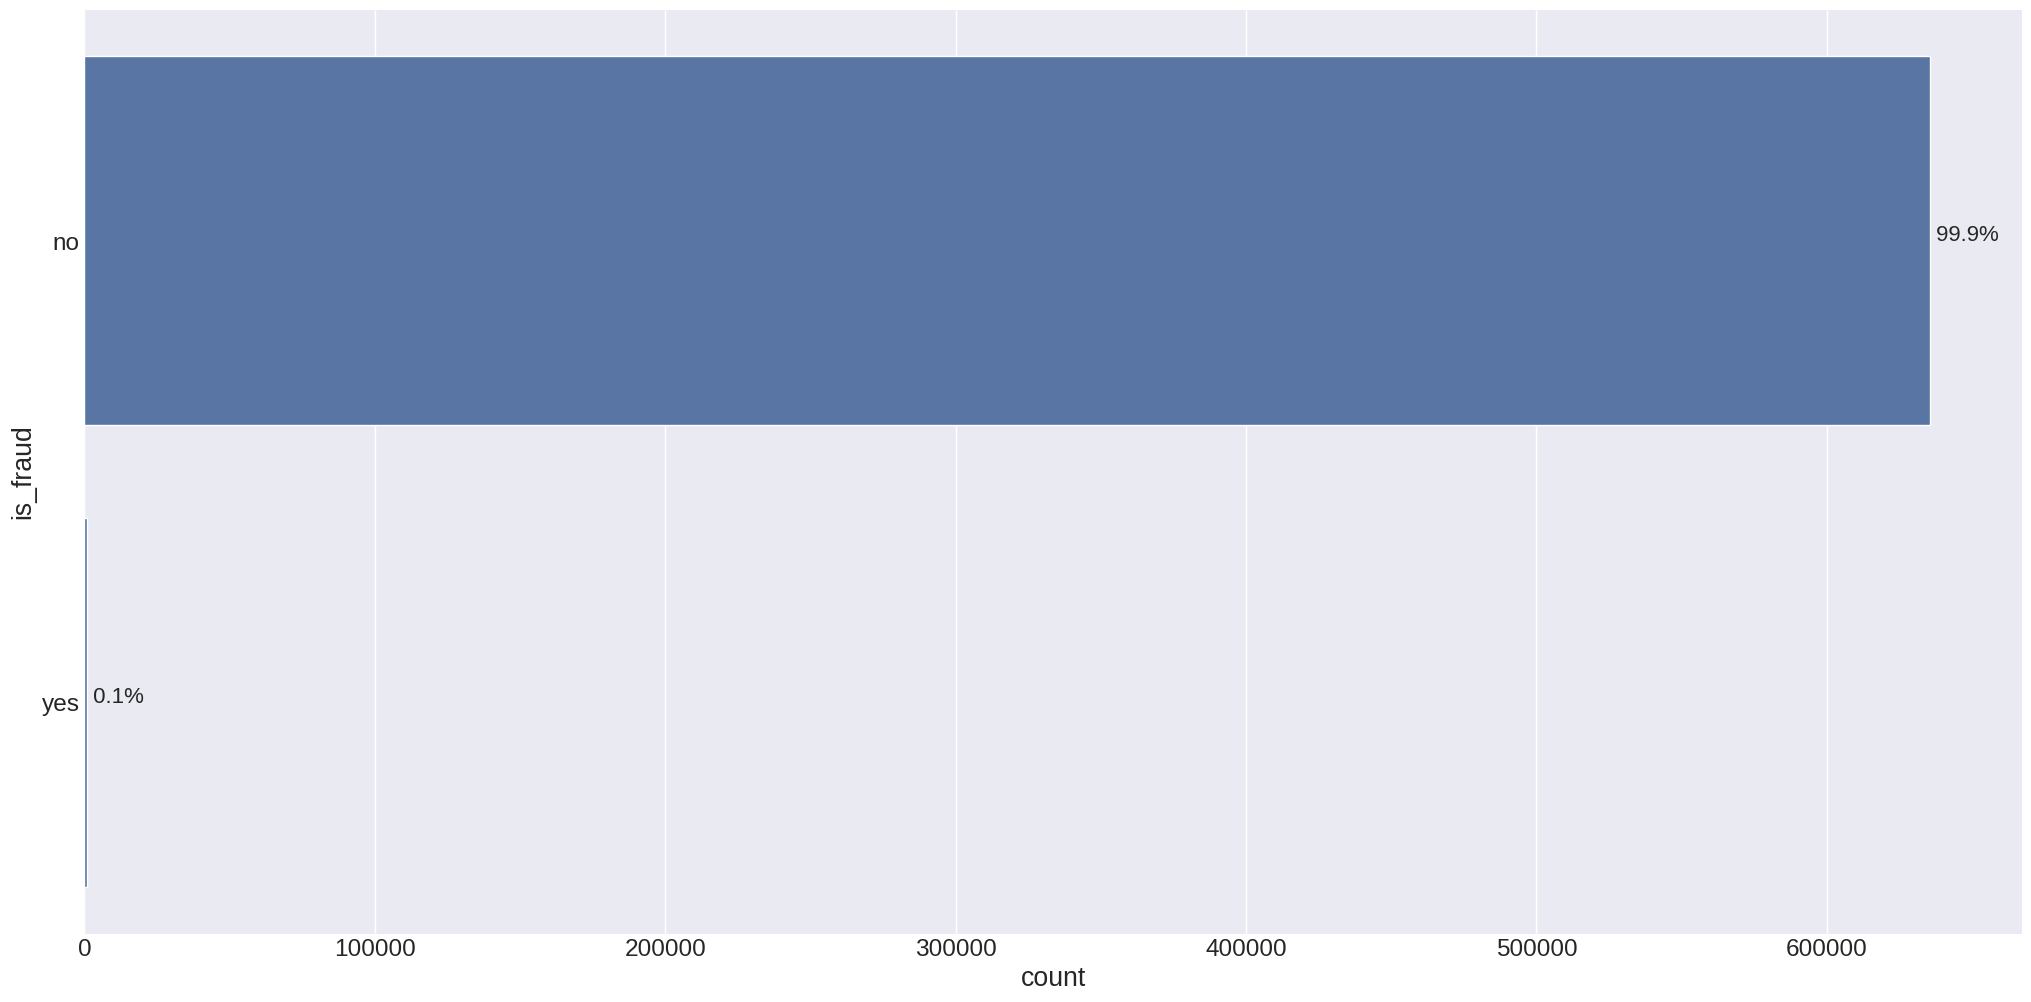

In [ ]:
ax = sns.countplot(y='is_fraud', data=df4);

total = df4['is_fraud'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### 4.1.2 Numerical Variables

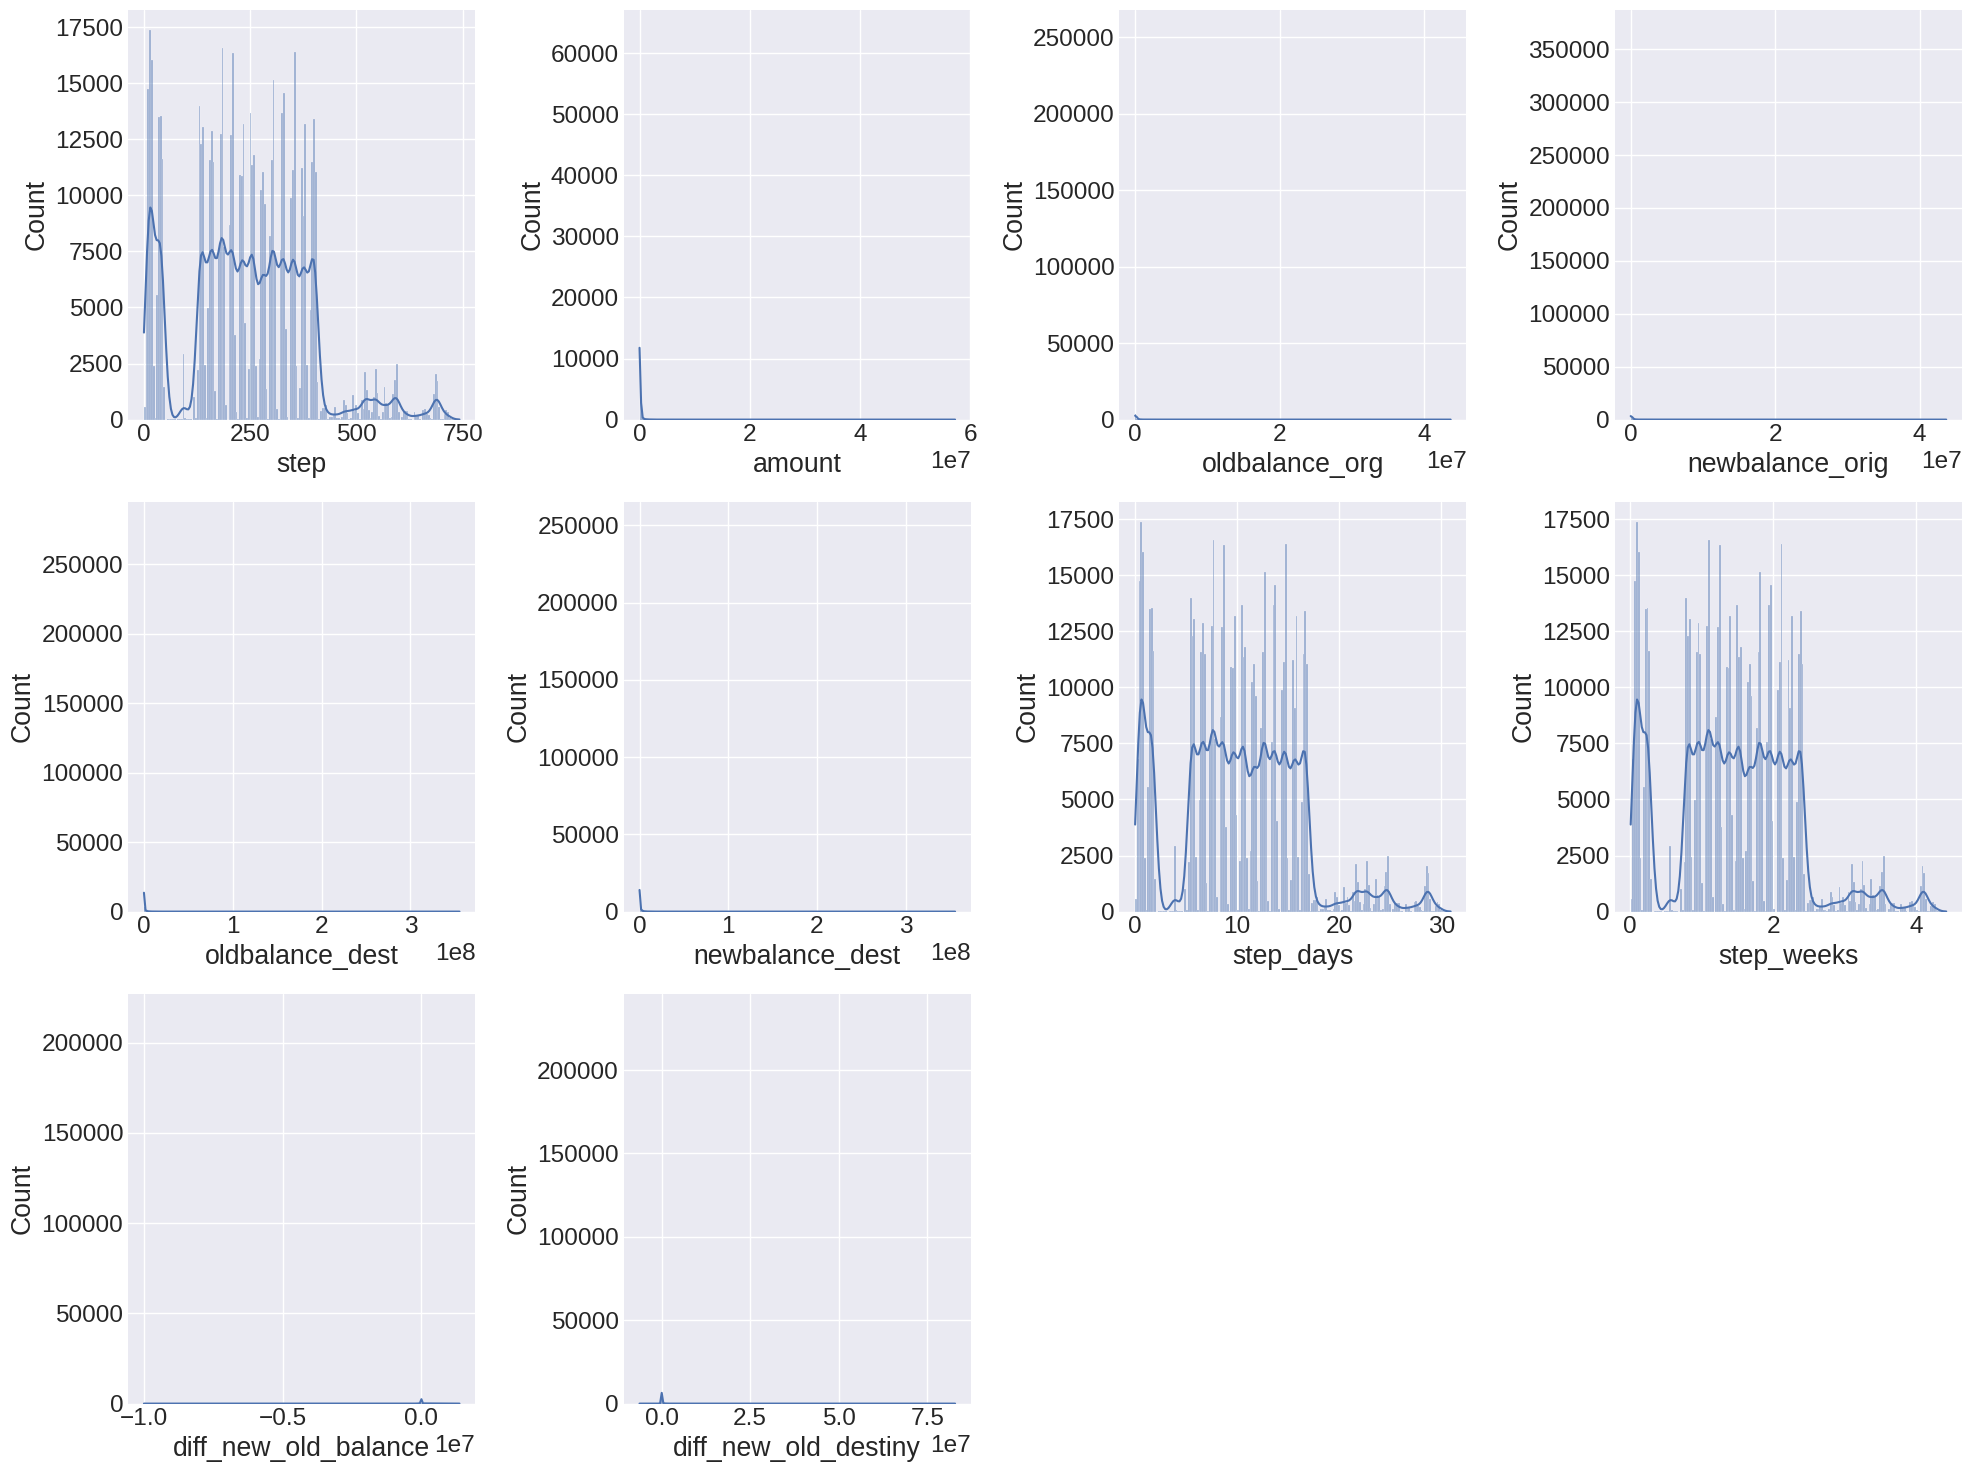

In [ ]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns.tolist()
j = 1

# Adjust the subplot grid based on the number of numerical columns
n_cols = 4
n_rows = (len(columns) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 5)) # Adjust figure size
for column in columns:
    plt.subplot(n_rows, n_cols, j)
    sns.histplot(num_attributes[column], kde=True); # Using histplot with kde for distribution

    j += 1

plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show() # Display the plot

### 4.1.3 Categorical Variables

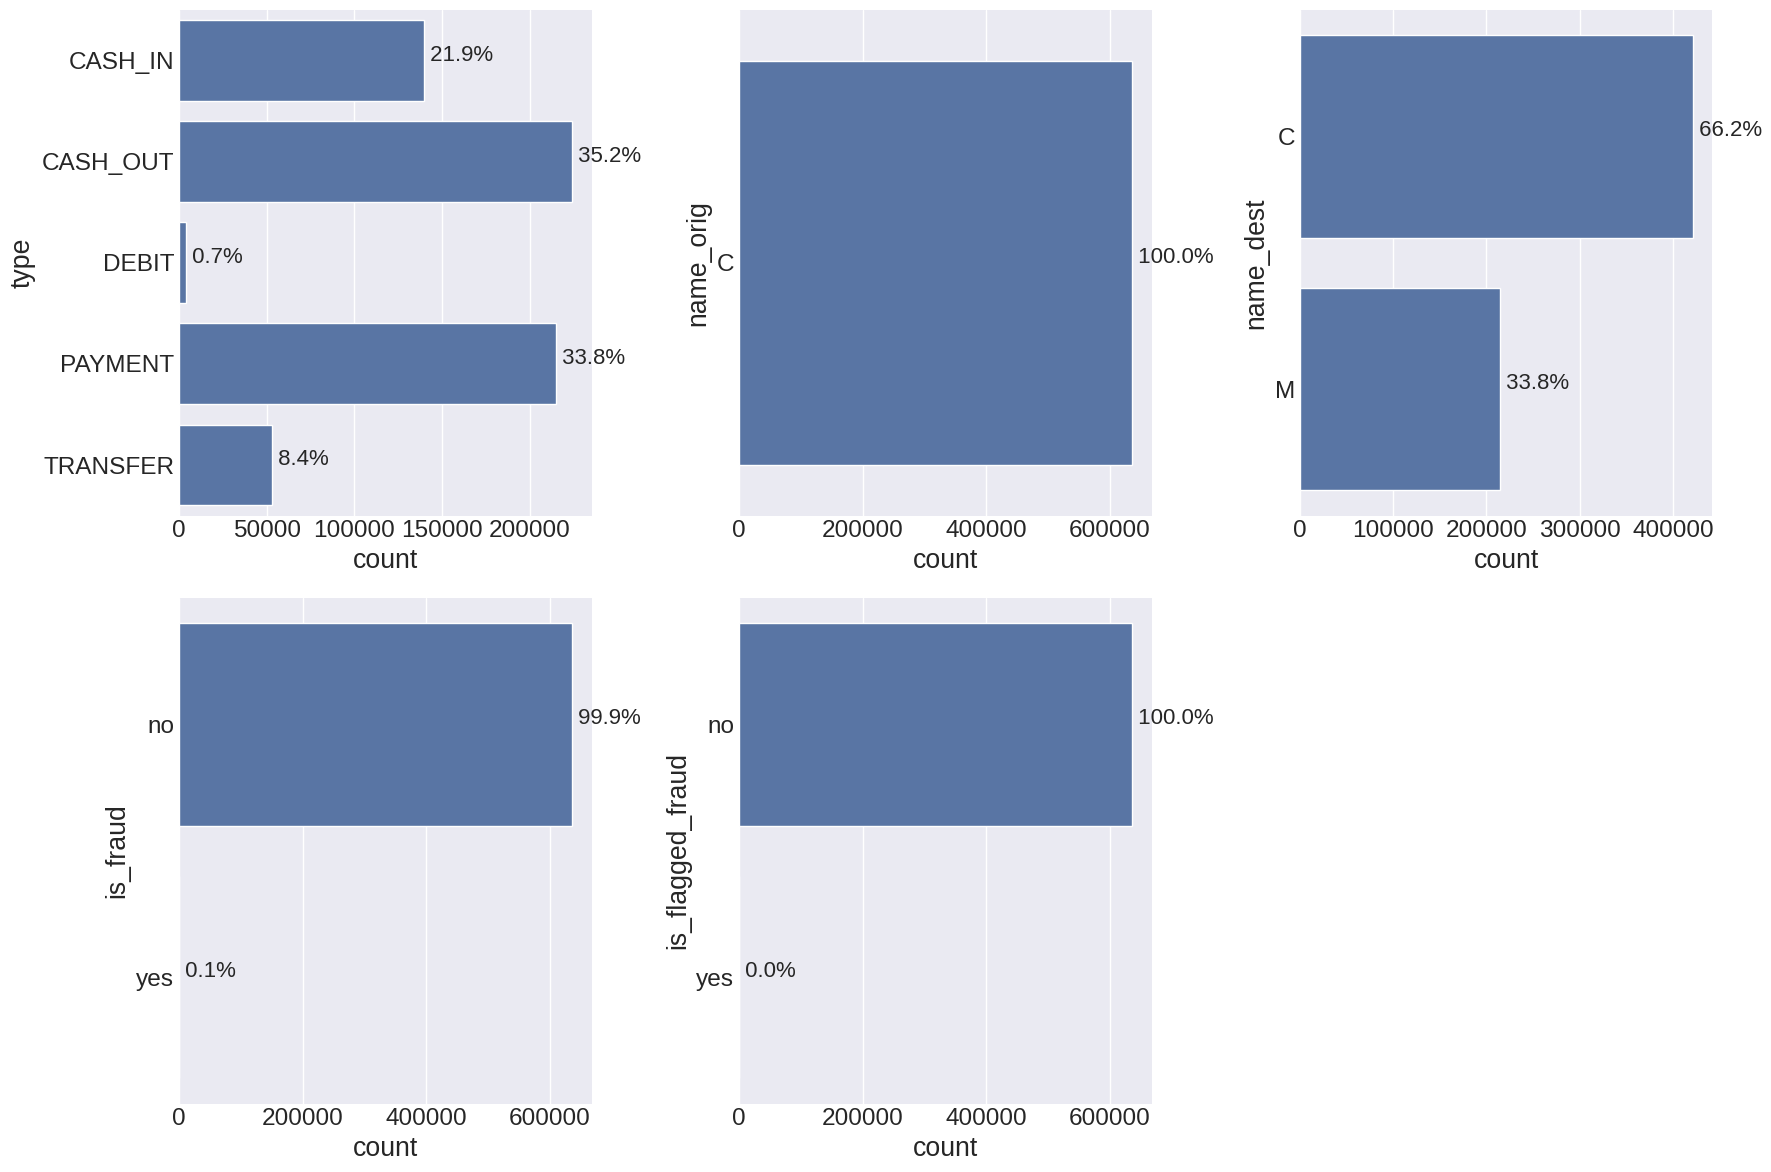

In [ ]:
cat_attributes = df4.select_dtypes(include='object')
columns = cat_attributes.columns.tolist()
j = 1

# Adjust the subplot grid based on the number of categorical columns
n_cols = 3 # Adjust number of columns as needed
n_rows = (len(columns) + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 6, n_rows * 6)) # Adjust figure size
for column in columns:
    plt.subplot(n_rows, n_cols, j)
    ax = sns.countplot(y=column, data=cat_attributes)

    total = cat_attributes[column].size
    for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

    j += 1

plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show() # Display the plot

## 4.2 Bivariate Analysis

### H1 The majority fraud transiction occours for the same user.
**TRUE:** The same user origem and destiny has got the same inital letter.

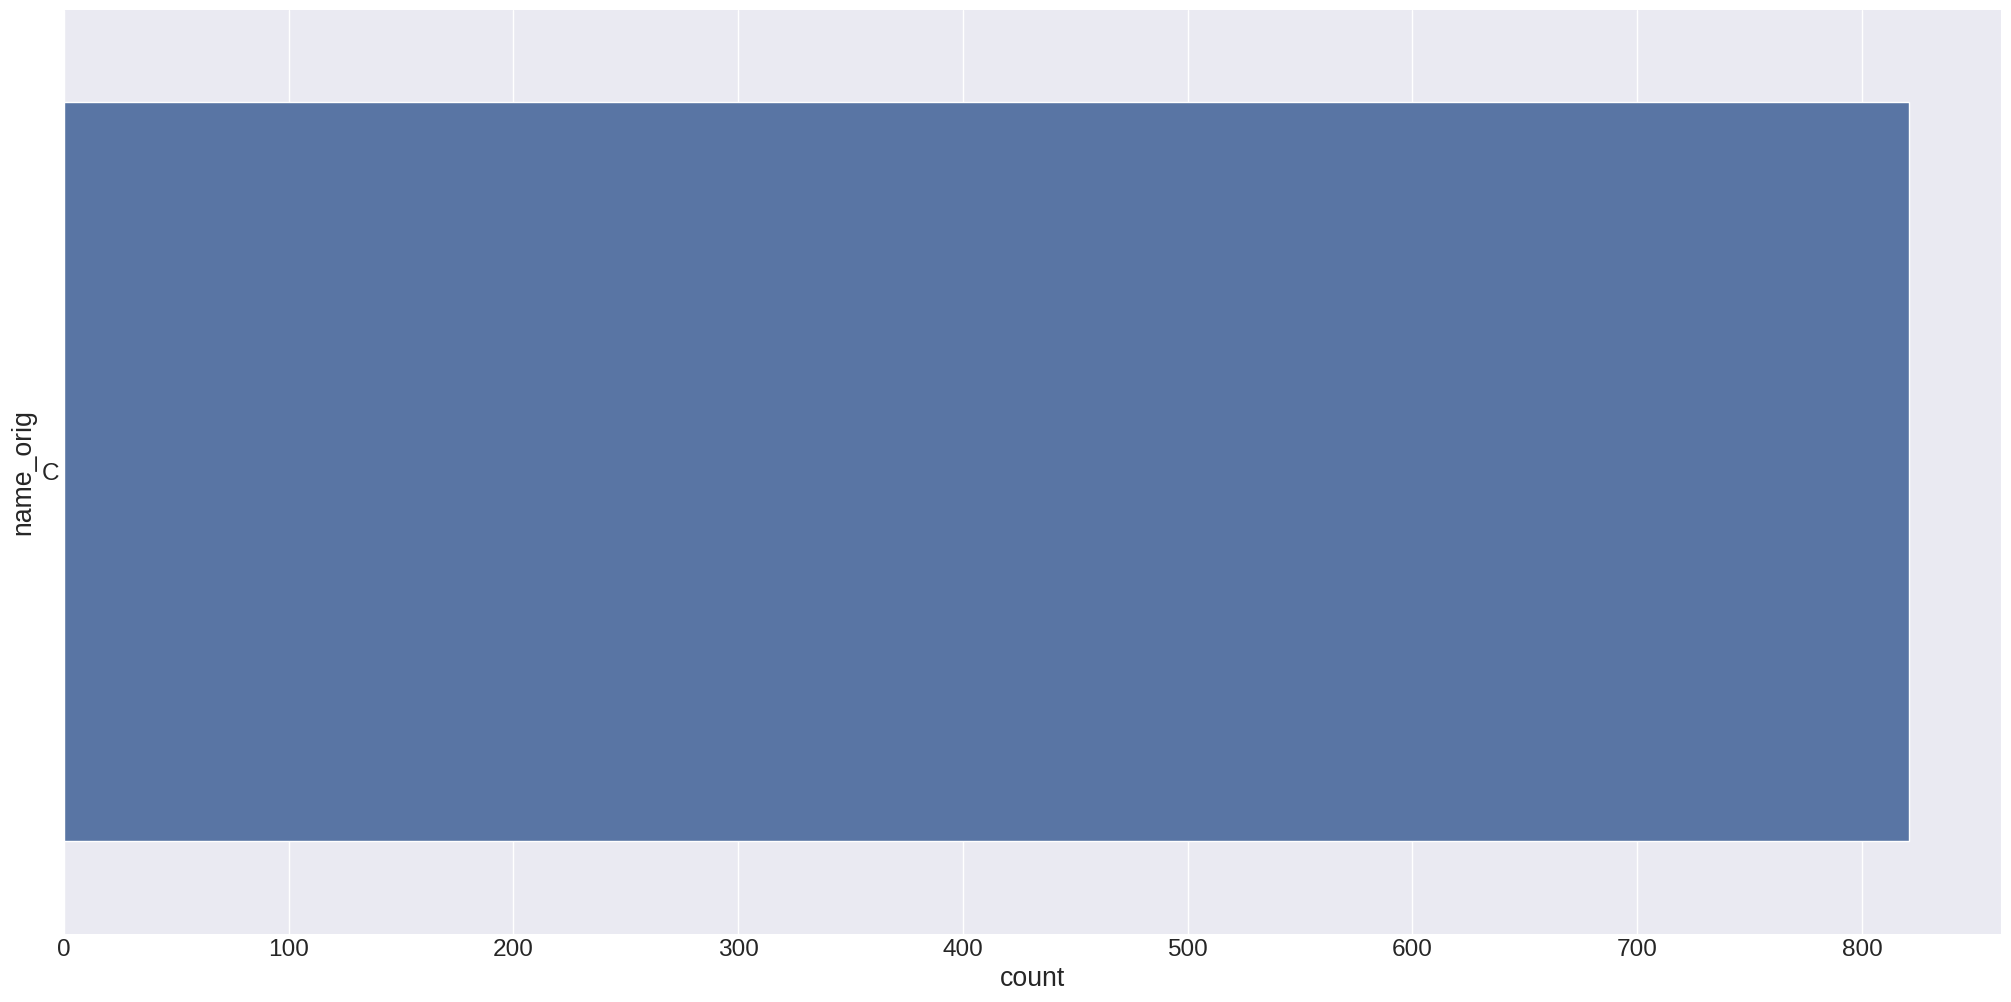

In [ ]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.countplot(y='name_orig', data=aux1);

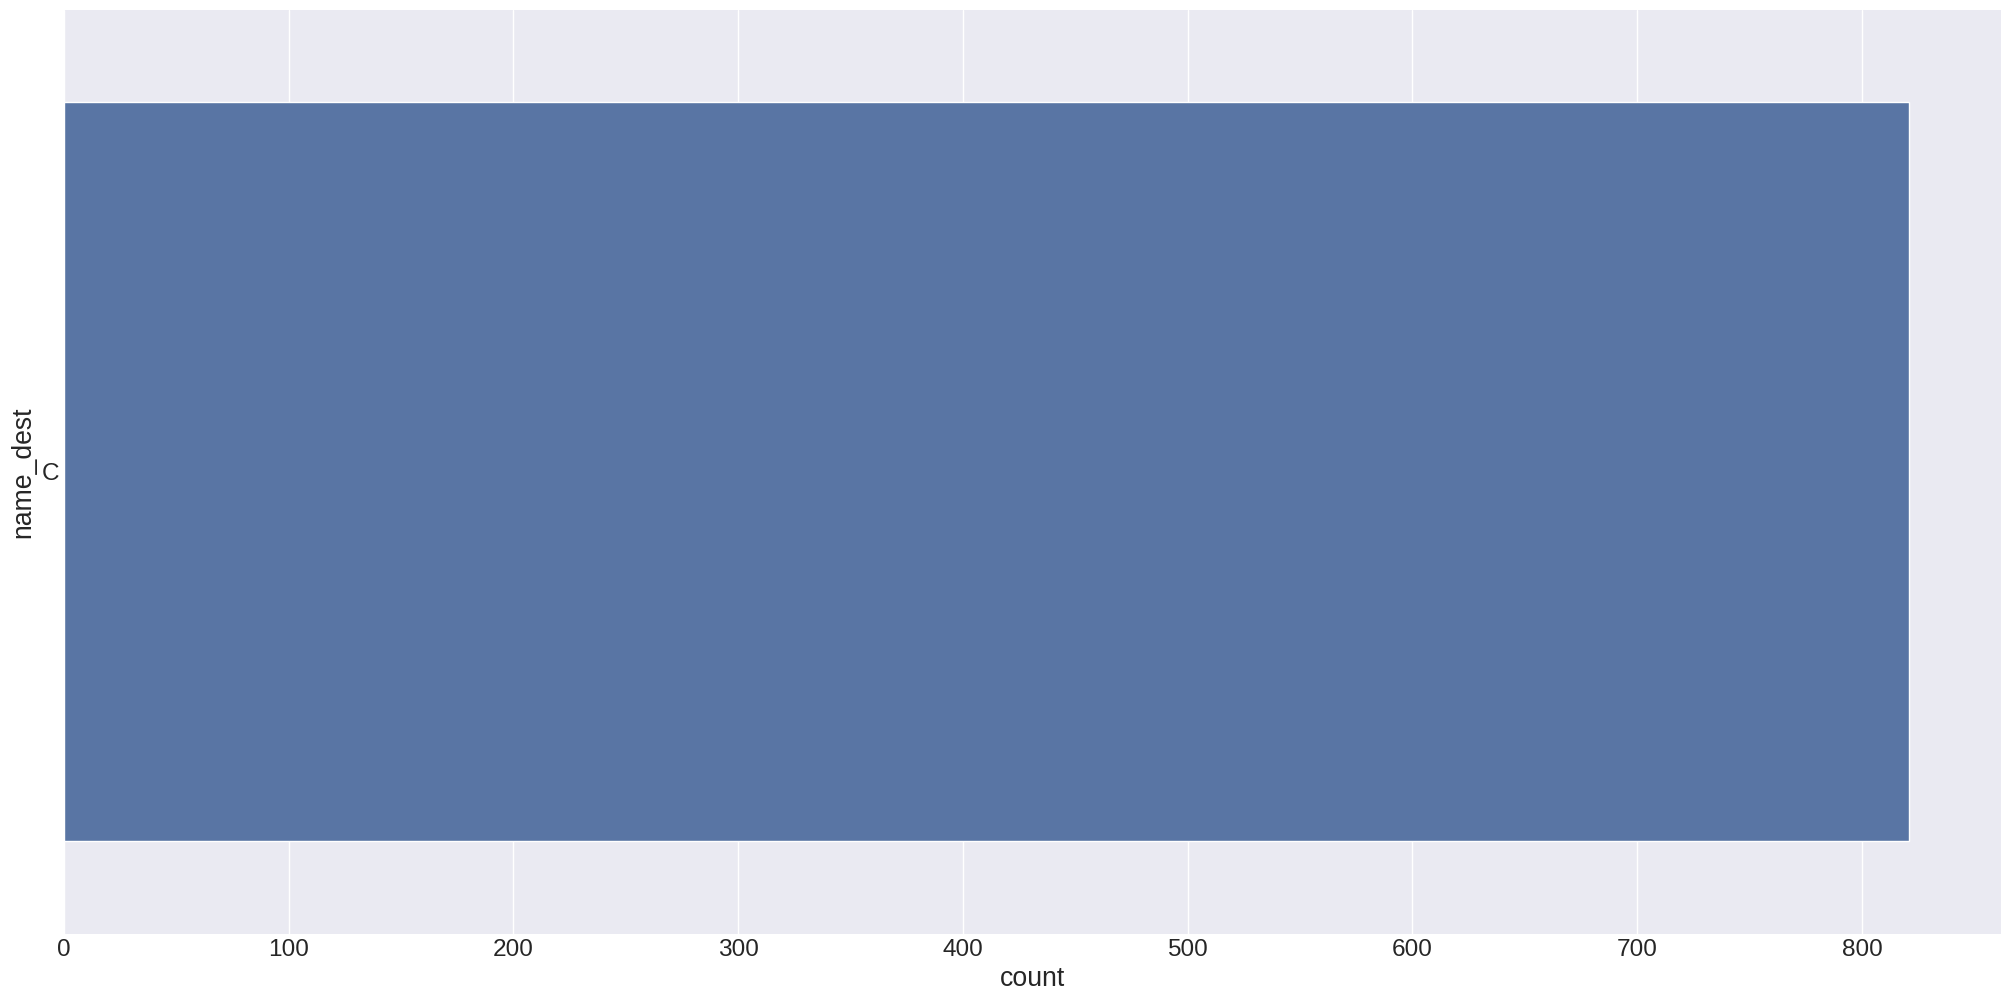

In [ ]:
sns.countplot(y='name_dest', data=aux1);

### H2 All the fraud amount is greater than 10.000.

**TRUE:** The values are greater than 10.000. But it's important to note that the no-fraud values is greater than 100.000 also.

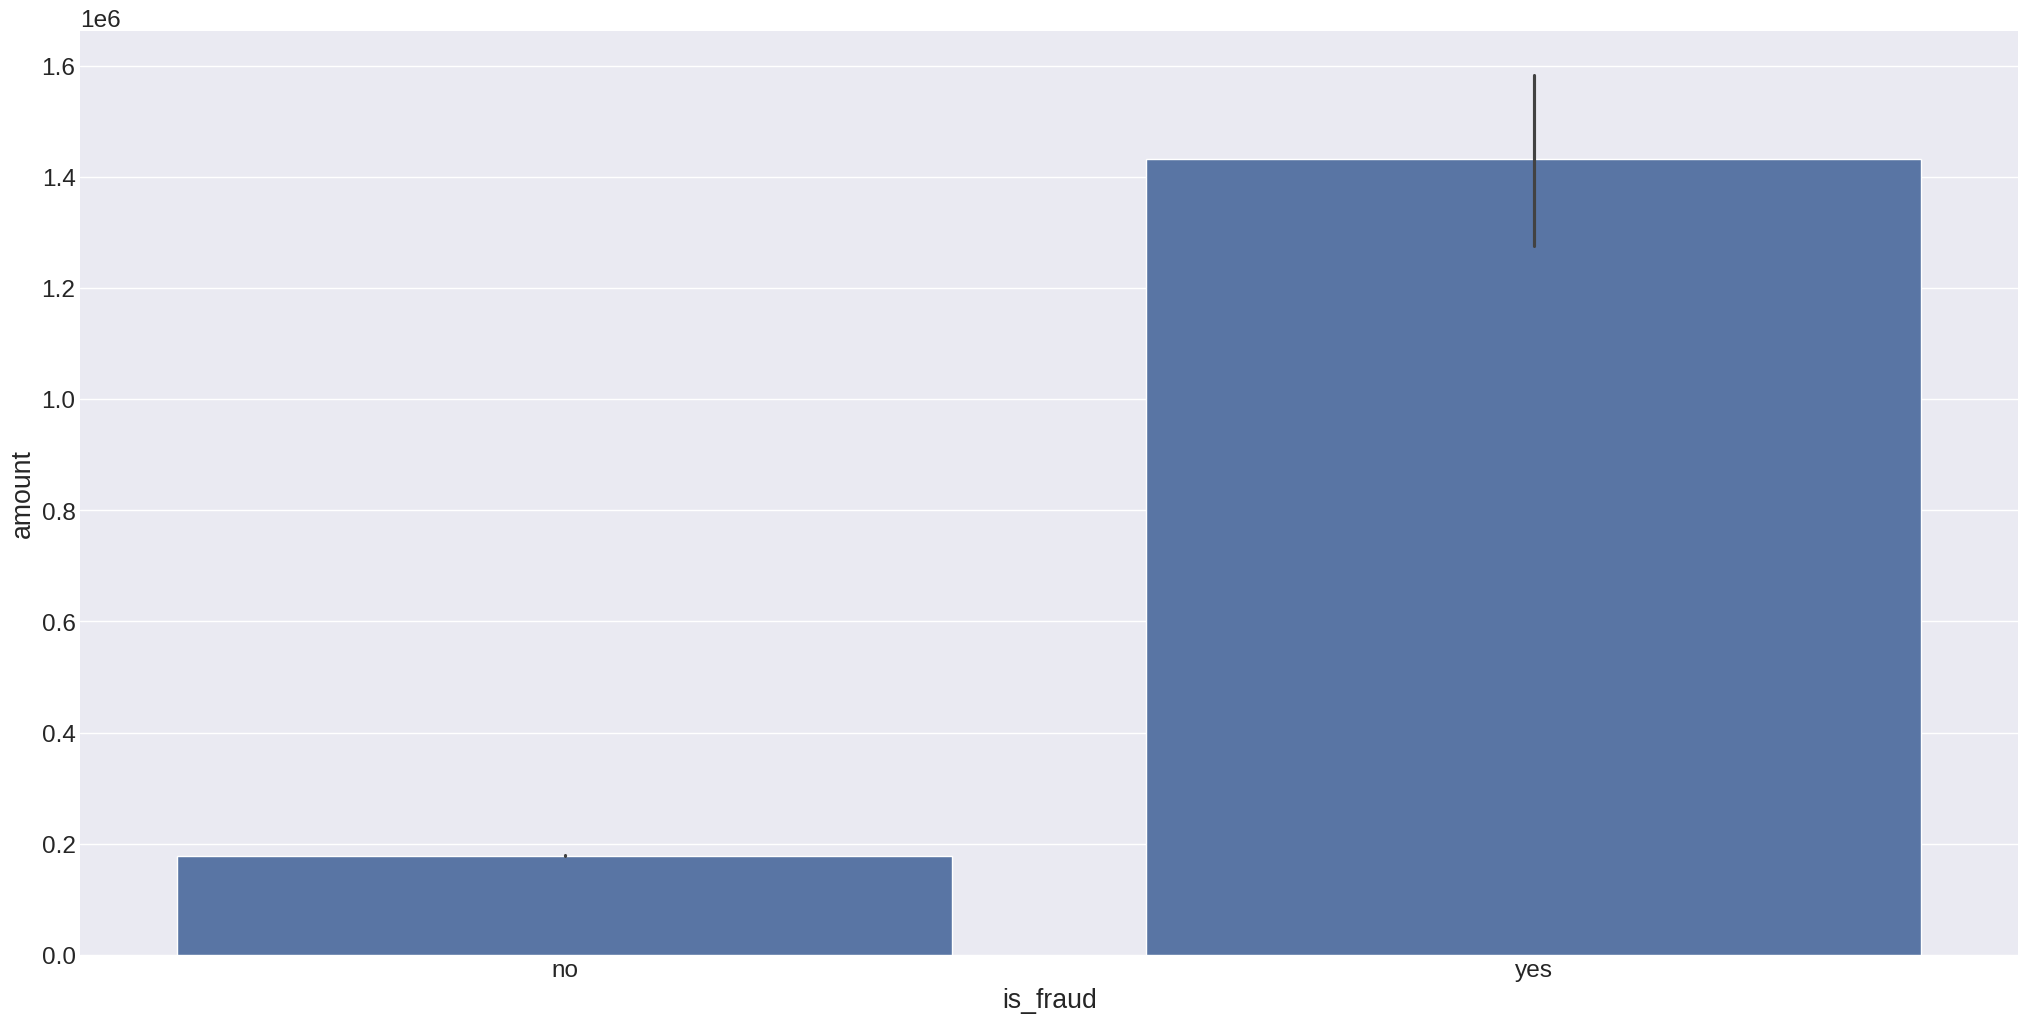

In [ ]:
sns.barplot(y='amount', x='is_fraud', data=df4);

### H3 60% of fraud transaction occours using cash-out-type method.

**FALSE:** The fraud transaction occours in transfer and cash-out type. However they're almost the same value.

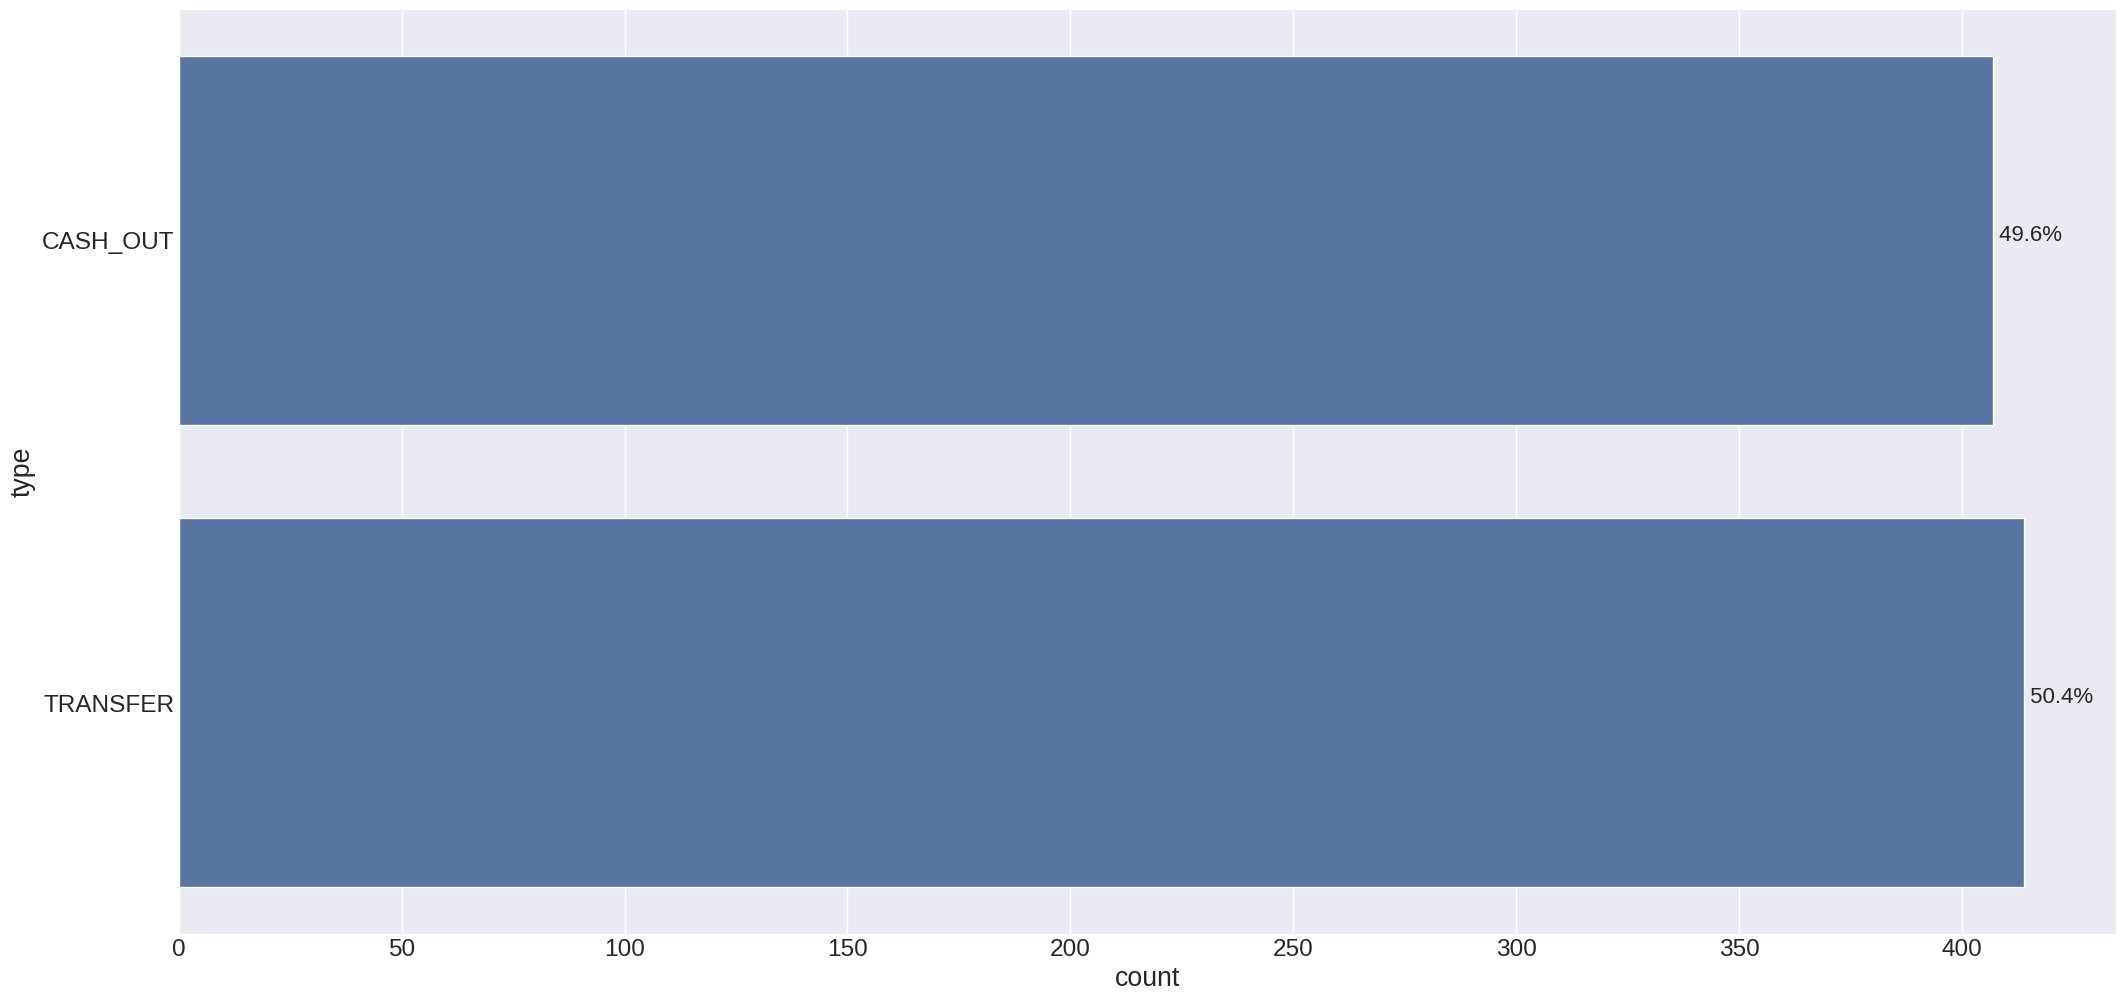

In [ ]:
aux1 = df4[df4['is_fraud'] == 'yes']
ax = sns.countplot(y='type', data=aux1)

total = aux1['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

To see the complete transiction-type and I'll plot them here.

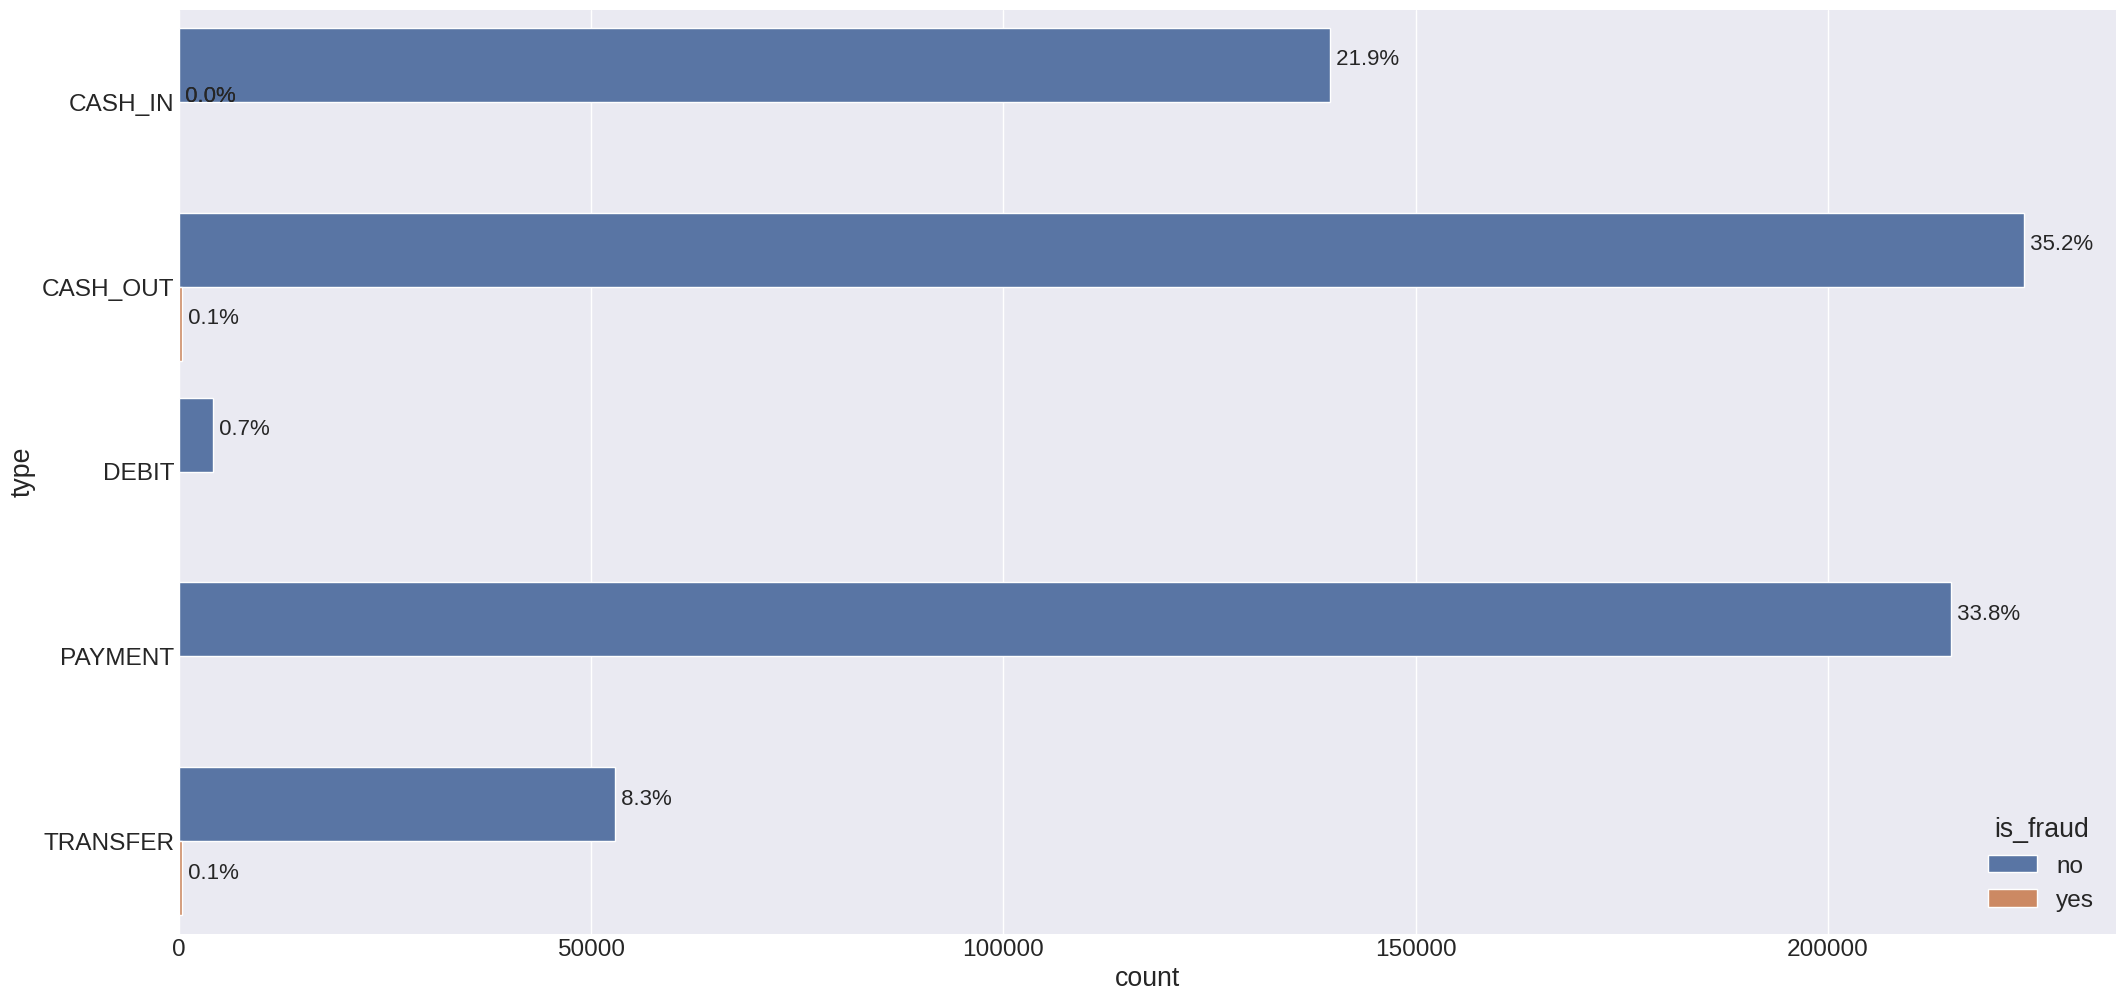

In [ ]:
ax = sns.countplot(y='type', hue='is_fraud', data=df4)

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

# Move the legend to the bottom right corner
ax.legend(loc='lower right', title='is_fraud')

### H4 Values greater than 100.000 occours using transfers-type method.

**FALSE:** The majority transactions occours in trasnfer-type, however transactions greater than 100.000 occour in cash-out and cash-in too.

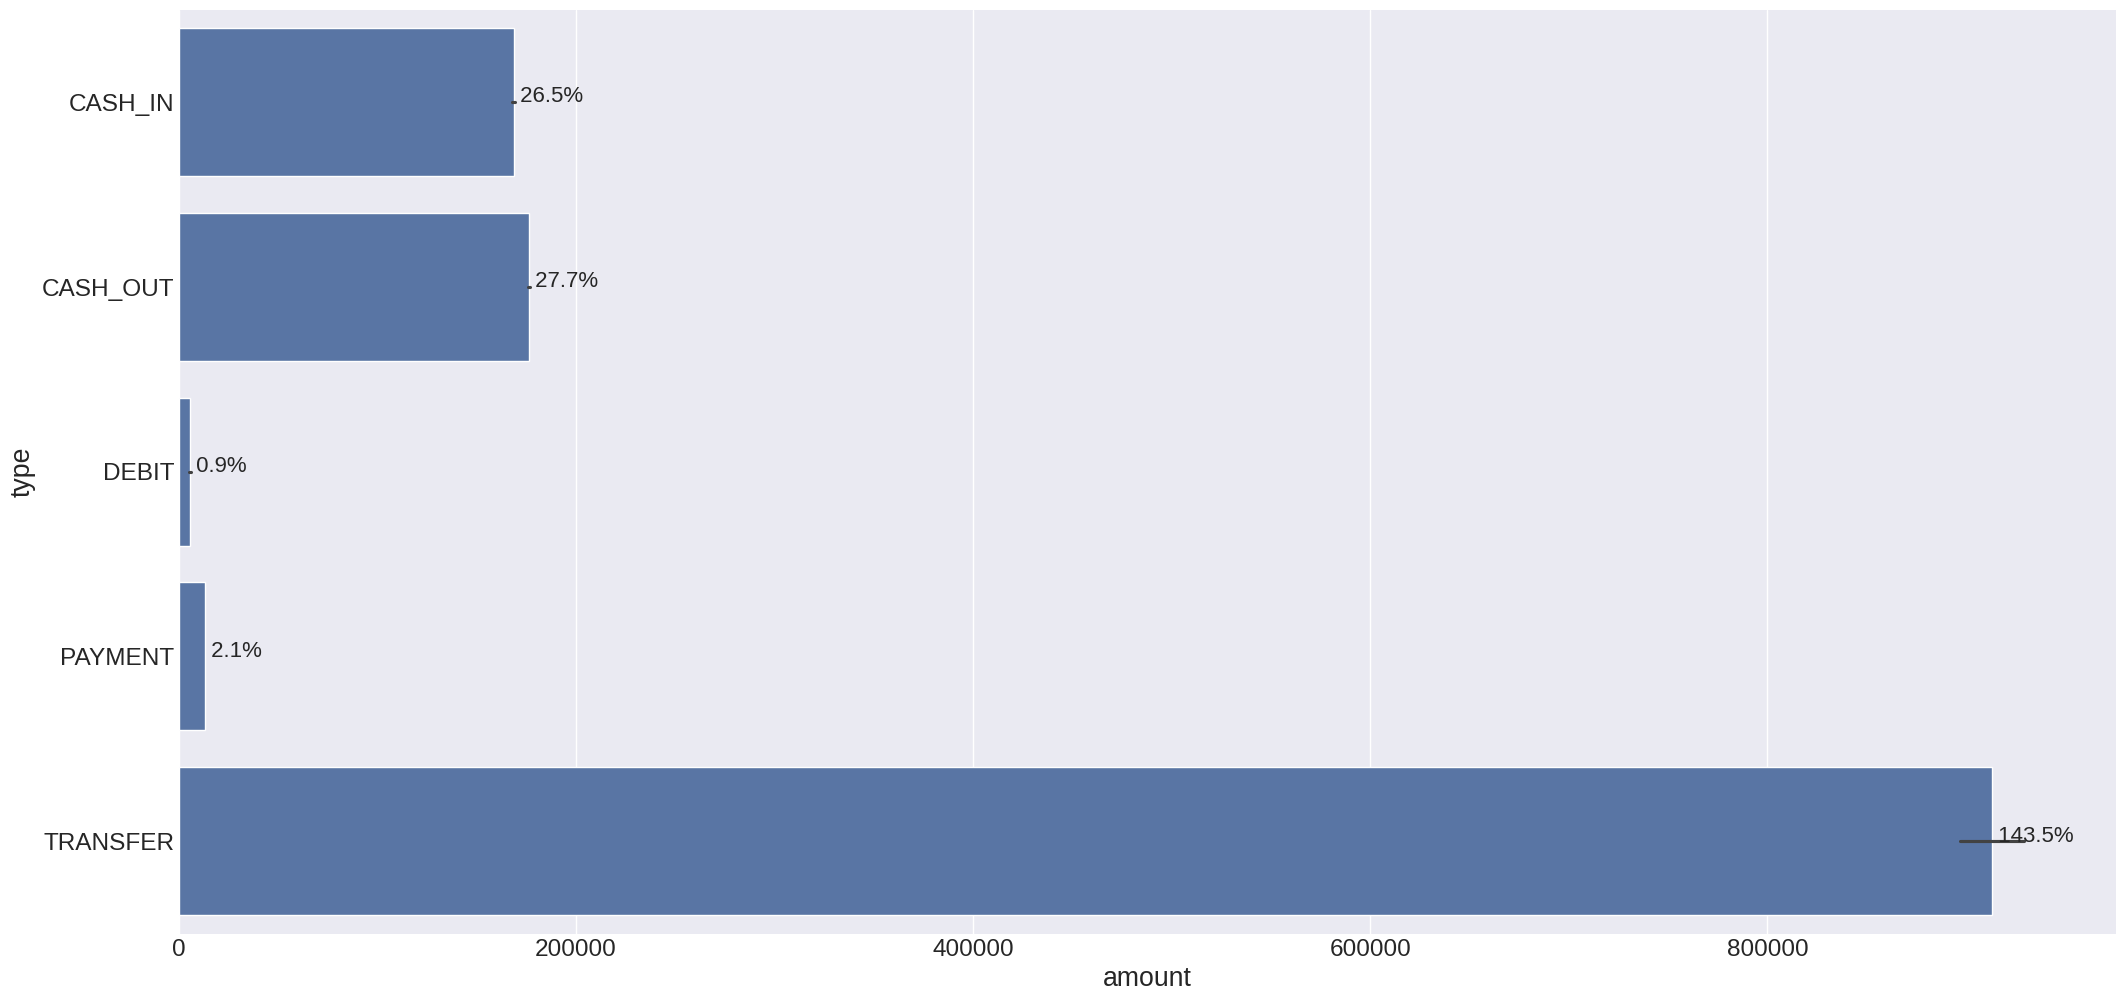

In [ ]:
ax = sns.barplot(y='type', x='amount', data=df4);

total = df4['type'].size
for p in ax.patches:
        percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

### H5 Fraud transactions occours at least in 3 days.

**TRUE:** The values for transactions and days in fraud aren't similar.

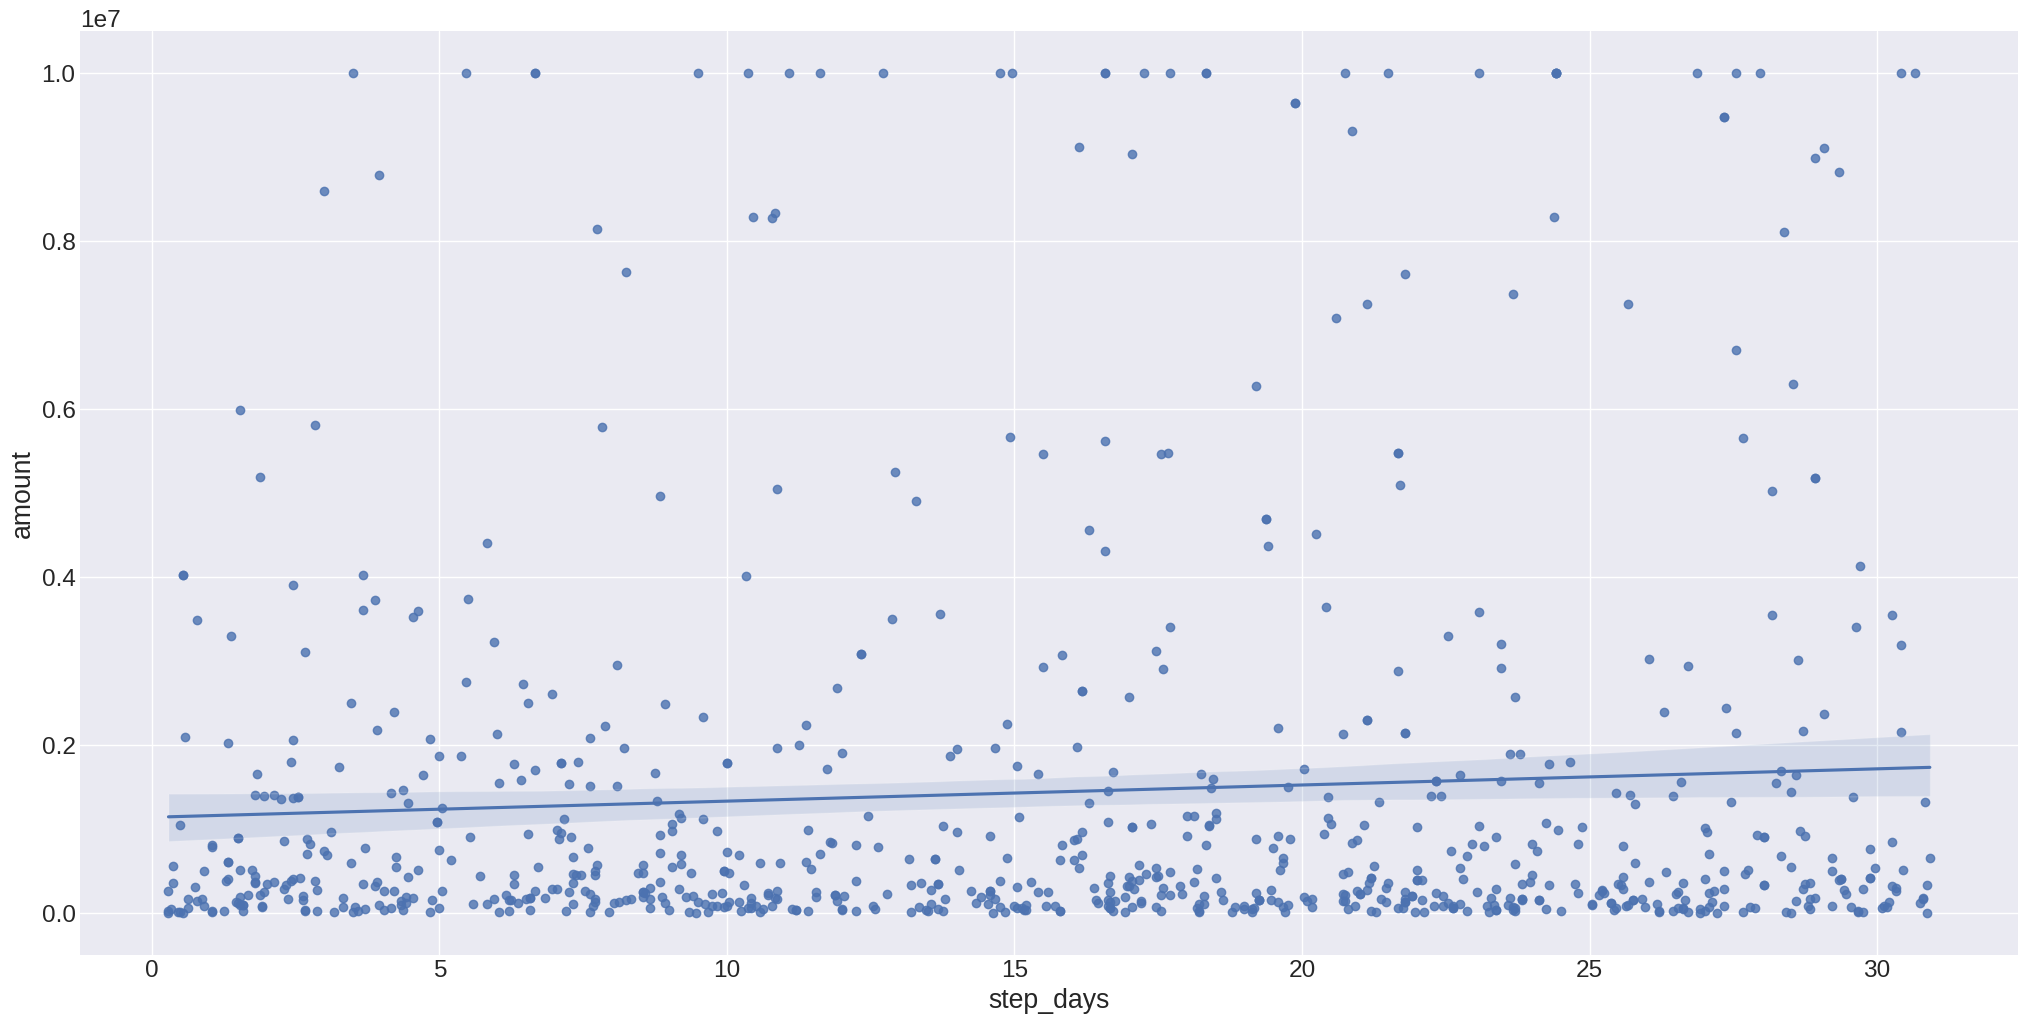

In [ ]:
aux1 = df4[df4['is_fraud'] == 'yes']
sns.regplot(x='step_days', y='amount', data=aux1);

## 4.3 Multivariaty Analysis

### 4.3.1 Numerical Analysis

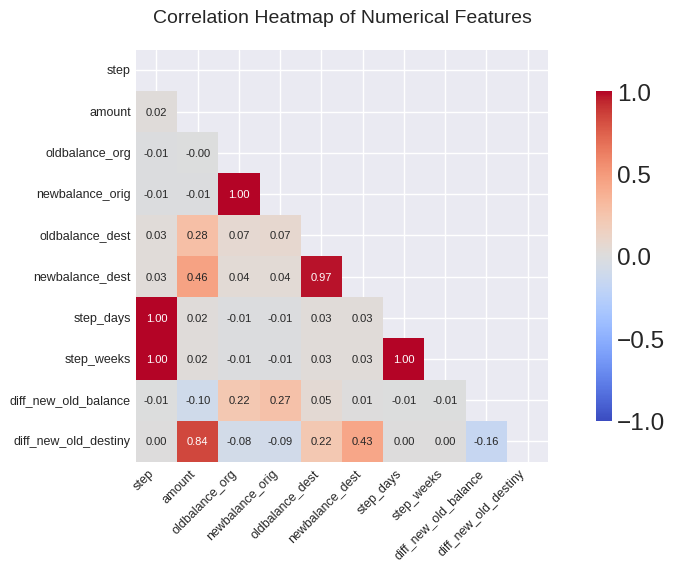

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Correlation matrix
corr = num_attributes.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set figure size
plt.figure(figsize=(10, 6))

# Heatmap
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt=".2f",        # show only 2 decimal points
    cmap="coolwarm",  # better color scheme
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    cbar_kws={"shrink": 0.8},  # shrink colorbar
    annot_kws={"size": 8}      # smaller font size
)

plt.title("Correlation Heatmap of Numerical Features", fontsize=14, pad=20)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
dict_corr = {}
columns = cat_attributes.columns.tolist()

for column in columns:
    dict_corr[column] = {}

    for column2 in columns:
        dict_corr[column][column2] = calcCramerV(cat_attributes[column], cat_attributes[column2])

corr = pd.DataFrame(dict_corr)

TypeError: 'float' object cannot be interpreted as an integer

### 4.3.2 Categorical Variables

# 5.0 Data Preparation

In [ ]:
df5 = df4.copy()

## 5.1 Spliting into Train, Valid and Test

In [ ]:
X = df5.drop(columns=['is_fraud', 'is_flagged_fraud', 'name_orig', 'name_dest',
                      'step_weeks', 'step_days'], axis=1)
y = df5['is_fraud'].map({'yes': 1, 'no': 0})

In [ ]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.2, stratify=y)

In [ ]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp)

## 5.2 One Hot Encoder

In [ ]:
print(df1.columns.tolist())

['step', 'type', 'amount', 'name_orig', 'oldbalance_org', 'newbalance_orig', 'name_dest', 'oldbalance_dest', 'newbalance_dest', 'is_fraud', 'is_flagged_fraud']


In [ ]:
print(X_train.columns.tolist())

['step', 'type_CASH_IN', 'type_CASH_OUT', 'type_TRANSFER', 'type_PAYMENT', 'type_DEBIT', 'amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest', 'diff_new_old_balance', 'diff_new_old_destiny']


In [ ]:
print("Columns in X_train before encoding:", X_train.columns.tolist())

Columns in X_train before encoding: ['step', 'type_CASH_IN', 'type_CASH_OUT', 'type_TRANSFER', 'type_PAYMENT', 'type_DEBIT', 'amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest', 'diff_new_old_balance', 'diff_new_old_destiny']


In [ ]:
ohe = OneHotEncoder(cols=['type'], use_cat_names=True)

X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

ValueError: X does not contain the columns listed in cols

## 5.3 Rescaling

In [ ]:
num_columns = ['amount', 'oldbalance_org', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest',
               'diff_new_old_balance', 'diff_new_old_destiny']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

# 6.0 Feature Selection

## 6.1 Boruta

In [ ]:
# X_boruta = X_params.values
# y_boruta = y_temp.values.ravel()

In [ ]:
# boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
# boruta.fit(X_boruta, y_boruta)

### 6.1.1 Best Features

In [ ]:
# cols_selected_boruta = boruta.support_.tolist()

In [ ]:
# columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [ ]:
# columns_selected

In [ ]:
# ['step',
#  'amount',
#  'oldbalance_org',
#  'newbalance_orig',
#  'oldbalance_dest',
#  'newbalance_dest',
#  'diff_new_old_balance',
#  'diff_new_old_destiny',
#  'type_TRANSFER']

In [ ]:
final_columns_selected = [
    "step", "oldbalance_org", "newbalance_orig",
    "newbalance_dest", "diff_new_old_balance",
    "diff_new_old_destiny",
    "type_TRANSFER", "type_CASH_OUT",
    "type_PAYMENT", "type_DEBIT", "type_CASH_IN"
]


In [ ]:
X_params_cs = select_columns_individually(X_params, final_columns_selected)

In [ ]:
X_train_cs = select_columns_individually(X_train, final_columns_selected)
X_valid_cs = select_columns_individually(X_valid, final_columns_selected)
X_temp_cs = select_columns_individually(X_temp, final_columns_selected)
X_test_cs = select_columns_individually(X_test, final_columns_selected)

# 7.0 Machine Learning Modeling

In [ ]:
def select_columns_individually(df, columns):
    df_selected = pd.DataFrame(index=df.index)
    for col in columns:
        if col in df.columns:
            df_selected[col] = df[col]
        else:
            print(f"Column '{col}' not found. Filling with 0s.")
            df_selected[col] = 0
    return df_selected


## 7.1 Baseline

In [ ]:
dummy = DummyClassifier()
dummy.fit(X_train_cs, y_train)

y_pred = dummy.predict(X_valid_cs)

In [ ]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.5,0.0,0.0,0.0,0.0


### 7.1.1 Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



### 7.1.2 Cross Validation

In [ ]:
dummy_cv = ml_cv_results('Dummy', DummyClassifier(), X_temp_cs, y_temp)
dummy_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0


## 7.2 Logistic Regression

In [ ]:
lg = LogisticRegression()
lg.fit(X_train_cs, y_train)

y_pred = lg.predict(X_valid_cs)

In [ ]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.538,1.0,0.076,0.142,0.142


### 7.2.1 Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       1.00      0.08      0.14       131

    accuracy                           1.00    101802
   macro avg       1.00      0.54      0.57    101802
weighted avg       1.00      1.00      1.00    101802



### 7.2.2 Cross Validation

In [ ]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(),
                      X_temp_cs, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.53 +/- 0.003,1.0 +/- 0.0,0.059 +/- 0.006,0.112 +/- 0.01,0.112 +/- 0.01


## 7.3 K Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_cs, y_train)

y_pred = knn.predict(X_valid_cs)

In [ ]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.573,0.905,0.145,0.25,0.25


### 7.3.1 Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.90      0.15      0.25       131

    accuracy                           1.00    101802
   macro avg       0.95      0.57      0.62    101802
weighted avg       1.00      1.00      1.00    101802



### 7.3.2 Cross Validation

In [ ]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(),
                       X_temp_cs, y_temp)
knn_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.706 +/- 0.018,0.949 +/- 0.034,0.412 +/- 0.035,0.575 +/- 0.04,0.574 +/- 0.04


## 7.4 Support Vector Machine

In [ ]:
svm = SVC()
svm.fit(X_train_cs, y_train)

y_pred = svm.predict(X_valid_cs)

In [ ]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.5,0.0,0.0,0.0,0.0


### 7.4.1 Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.00      0.00      0.00       131

    accuracy                           1.00    101802
   macro avg       0.50      0.50      0.50    101802
weighted avg       1.00      1.00      1.00    101802



### 7.4.2 Cross Validation

In [ ]:
svm_cv = ml_cv_results('SVM', SVC(), X_temp_cs, y_temp)
svm_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.58 +/- 0.016,1.0 +/- 0.0,0.16 +/- 0.032,0.274 +/- 0.046,0.274 +/- 0.046


## 7.5 Random Forest

In [ ]:
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_cs, y_train)

y_pred = rf.predict(X_valid_cs)

In [ ]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.855,0.969,0.71,0.819,0.819


### 7.5.1 Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.97      0.71      0.82       131

    accuracy                           1.00    101802
   macro avg       0.98      0.85      0.91    101802
weighted avg       1.00      1.00      1.00    101802



### 7.5.2 Cross Validation

In [ ]:
rf_cv = ml_cv_results('Random Forest',
                      RandomForestClassifier(),
                      X_temp_cs, y_temp)
rf_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.865 +/- 0.021,0.969 +/- 0.017,0.729 +/- 0.042,0.832 +/- 0.031,0.832 +/- 0.031


## 7.6 XGBoost

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train_cs, y_train)

y_pred = xgb.predict(X_valid_cs)

In [ ]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.866,0.85,0.733,0.787,0.787


### 7.6.1 Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    101671
           1       0.85      0.73      0.79       131

    accuracy                           1.00    101802
   macro avg       0.92      0.87      0.89    101802
weighted avg       1.00      1.00      1.00    101802



### 7.6.2 Cross Validation

In [ ]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(),
                       X_temp_cs, y_temp)
xgb_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.875 +/- 0.029,0.902 +/- 0.032,0.751 +/- 0.059,0.818 +/- 0.041,0.818 +/- 0.041


## 7.7 LightGBM

In [ ]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train_cs, y_train)

y_pred = lightgbm.predict(X_valid_cs)

[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483


In [ ]:
lightgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lightgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.633,0.04,0.275,0.07,0.067


### 7.7.1 Classification Report

In [ ]:
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    101671
           1       0.04      0.27      0.07       131

    accuracy                           0.99    101802
   macro avg       0.52      0.63      0.53    101802
weighted avg       1.00      0.99      0.99    101802



### 7.7.2 Cross Validation

In [ ]:
lightgbm_cv = ml_cv_results('LightGDM', LGBMClassifier(),
                            X_temp_cs, y_temp)
lightgbm_cv

Fold K=1
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> initscore=-6.650483
[LightGBM] [Info] Start training from score -6.650483
Fold K=2
[LightGBM] [Info] Number of positive: 526, number of negative: 406681
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1540
[LightGBM] [Info] Number of data points in the train set: 407207, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001292 -> init

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGDM,0.713 +/- 0.071,0.247 +/- 0.18,0.433 +/- 0.141,0.29 +/- 0.187,0.288 +/- 0.188


## 7.8 Comparing Model's Performance

### 7.8.1 Single Performance

In [ ]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results,
                                  rf_results, xgb_results, lightgbm_results,
                                 svm_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.500,0.000,0.000,0.000,0.000
SVM,0.500,0.000,0.000,0.000,0.000
LightGBM,0.633,0.040,0.275,0.070,0.067
Logistic Regression,0.538,1.000,0.076,0.142,0.142
K Nearest Neighbors,0.573,0.905,0.145,0.250,0.250
XGBoost,0.866,0.850,0.733,0.787,0.787
Random Forest,0.855,0.969,0.710,0.819,0.819


### 7.8.2 Cross Validation Performance

In [ ]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, rf_cv,
                                     xgb_cv, lightgbm_cv, svm_cv])

modeling_performance_cv.sort_values(by="F1", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Dummy,0.5 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0,0.0 +/- 0.0
Logistic Regression,0.53 +/- 0.003,1.0 +/- 0.0,0.059 +/- 0.006,0.112 +/- 0.01,0.112 +/- 0.01
SVM,0.58 +/- 0.016,1.0 +/- 0.0,0.16 +/- 0.032,0.274 +/- 0.046,0.274 +/- 0.046
LightGDM,0.713 +/- 0.071,0.247 +/- 0.18,0.433 +/- 0.141,0.29 +/- 0.187,0.288 +/- 0.188
K Nearest Neighbors,0.706 +/- 0.018,0.949 +/- 0.034,0.412 +/- 0.035,0.575 +/- 0.04,0.574 +/- 0.04
XGBoost,0.875 +/- 0.029,0.902 +/- 0.032,0.751 +/- 0.059,0.818 +/- 0.041,0.818 +/- 0.041
Random Forest,0.865 +/- 0.021,0.969 +/- 0.017,0.729 +/- 0.042,0.832 +/- 0.031,0.832 +/- 0.031


# 8.0 Hyperparameter Fine Tuning

In [ ]:
f1 = make_scorer(f1_score)

In [ ]:
params = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.1, 0.01],
    'scale_pos_weight': [1, 774, 508, 99]
}

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Parameter space (not too big to avoid long runtime)
params = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 5, 7, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1],
    "colsample_bytree": [0.7, 0.9, 1],
    "scale_pos_weight": [1, 5, 10, 20]
}

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)

# Use RandomizedSearch instead of GridSearch
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=params,
    n_iter=10,  # only test 10 random combos
    scoring="f1",
    cv=StratifiedKFold(n_splits=3),
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# ⚡ Use a sample of the dataset for speed
X_sample = X_params_cs.sample(20000, random_state=42)
y_sample = y_temp.loc[X_sample.index]

# Fit RandomizedSearch
search.fit(X_sample, y_sample)

print("Best parameters:", search.best_params_)

# Train the final model on full dataset with best params
best_model = XGBClassifier(
    **search.best_params_,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
)
best_model.fit(X_params_cs, y_temp)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters: {'subsample': 1, 'scale_pos_weight': 10, 'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
best_params = search.best_params_
best_params

{'subsample': 1,
 'scale_pos_weight': 10,
 'n_estimators': 600,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 0.9}

In [ ]:
best_params = {'booster': 'gbtree', 'eta': 0.3, 'scale_pos_weight': 1}

In [ ]:
search.best_score_

np.float64(0.6238095238095238)

## 8.1 Results

In [ ]:
xgb_gs = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [ ]:
search.fit(X_train_cs, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=N...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.9, 1],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [200, 400, 600],
                                        'scale_pos_weight': [1, 5, 10, 20],
                                        'subsample': [0.7, 0.9, 1]},
                   random_state=42, scoring='f1', verbose=1)

In [ ]:
y_pred = search.predict(X_valid_cs)

### 8.1.2 Single Results

In [ ]:
xgb_rs_results = ml_scores('XGBoost RS', y_valid, y_pred)
xgb_rs_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost RS,0.878,0.943,0.756,0.839,0.839


### 8.1.3 Cross Validation

In [ ]:
xgb_rs_cv = ml_cv_results('XGBoost RS', search.best_estimator_, X_temp_cs, y_temp)
xgb_rs_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost RS,0.882 +/- 0.01,0.946 +/- 0.014,0.764 +/- 0.019,0.845 +/- 0.014,0.845 +/- 0.014


# 9.0 Conclusions

## 9.1 Final Model

In [ ]:
final_model = XGBClassifier(
    booster=best_params['booster'],
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_cs, y_temp)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

### 9.1.1 Unseen Data Score

In [ ]:
y_pred = final_model.predict(X_test_cs)

In [ ]:
unseen_scores = ml_scores('unseen', y_test, y_pred)
unseen_scores

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.912,0.918,0.823,0.868,0.868


## 9.2 Blocker Fraud Company Expasion

### 9.2.1 The company receives 25% of each transaction value truly detected as fraud.

In [ ]:
df_test = df5.loc[X_test.index, :]
df_test['predictions'] = y_pred

In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.25

In [ ]:
print('The company can receive %.2f detecting fraud transactions.' % (receives))

The company can receive 60532001.08 detecting fraud transactions.


### 9.2.2 The company receives 5% of each transaction value detected as fraud, however the transaction is legitimate.

In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'no') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.05

print('For wrong decisions, the company can receive %.2f.' % (receives))

For wrong decisions, the company can receive 261979.82.


### 9.2.3 The company gives back 100% of the value for the customer in each transaction detected as legitimate, however the transaction is actually a fraud.

In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 0)]
receives = aux1['amount'].sum()

print('However, the company must return the amount of %.2f.' % (receives))

However, the company must return the amount of 3873202.60.


## 9.3 Model's Performance

### 9.3.1 What is the model's Precision and Accuracy?

In [ ]:
print('For unseen data, the values of balanced accuracy is equal %.2f and precision is equal %.2f.' % (unseen_scores['Balanced Accuracy'], unseen_scores['Precision']))

For unseen data, the values of balanced accuracy is equal 0.91 and precision is equal 0.92.


### 9.3.2 How reliable is the model in classifying transactions as legitimate or fraudulent?

In [ ]:
print('The model can detect 0.851 +/- 0.023 of the fraud. However it detected 0.84 of the frauds from a unseen data.')

The model can detect 0.851 +/- 0.023 of the fraud. However it detected 0.84 of the frauds from a unseen data.


### 9.3.3 What is the revenue expected by the company  classify 100% of transactions with the model?

In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 1)]
receives = aux1['amount'].sum() * 0.25

aux2 = df_test[(df_test['is_fraud'] == 'no') & (df_test['predictions'] == 1)]
receives2 = aux2['amount'].sum() * 0.05

print('Using the model the company can revenue %.2f.' % (receives + receives2))

Using the model the company can revenue 60793980.90.


In [ ]:
aux3 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['is_flagged_fraud'] == 'yes')]
curr_receives = aux3['amount'].sum() * 0.25

aux4 = df_test[(df_test['is_fraud'] == 'no') & (df_test['is_flagged_fraud'] == 'yes')]
curr_receives2 = aux4['amount'].sum() * 0.05

print('However the currently method the revenue is %.2f.' % (curr_receives + curr_receives2))

However the currently method the revenue is 0.00.


### 9.3.4 What is the loss expected by the Company if it classifies 100% of the transactions with the model?

In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['predictions'] == 0)]
loss = aux1['amount'].sum()

print('For wrong classifications the company must return the amount of %.2f.' % (loss))

For wrong classifications the company must return the amount of 3873202.60.


In [ ]:
aux1 = df_test[(df_test['is_fraud'] == 'yes') & (df_test['is_flagged_fraud'] == 'no')]
curr_loss = aux1['amount'].sum()

print('For wrong classifications using the currently method, the company must return the amount of %.2f.' % (curr_loss))

For wrong classifications using the currently method, the company must return the amount of 246001206.94.


### 9.3.5 What is the profit expected by the blocker fraud company when using the model?

In [ ]:
print('The company can expect the profit of %.2f.' % (receives + receives2 - loss))

The company can expect the profit of 56920778.30.


In [ ]:
print('Using the currently method, the profit is %.2f.' % (curr_receives + curr_receives - curr_loss))

Using the currently method, the profit is -246001206.94.


# 10.0 Model Deploy

## 10.1 Saving

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
import joblib

# numeric and categorical columns
num_columns = [
    "amount", "oldbalance_org", "newbalance_orig",
    "oldbalance_dest", "newbalance_dest",
    "diff_new_old_balance", "diff_new_old_destiny"
]

# 1. Fit scaler
mm = MinMaxScaler()
mm.fit(X_temp[num_columns])
joblib.dump(mm, "minmaxscaler_cycle1.joblib")

# 2. Fit category_encoders OneHotEncoder
joblib.dump(ohe, "onehotencoder_cycle1.joblib")

# 3. Save final trained model
joblib.dump(final_model, "fraud_model.pkl")

print("✅ Scaler, category_encoders OneHotEncoder, and Model saved successfully!")


✅ Scaler, category_encoders OneHotEncoder, and Model saved successfully!


## 10.2 Fraud Class

In [ ]:
import pandas as pd
import joblib
import inflection

class Fraud:

    def __init__(self):
        # Load fitted scaler
        self.minmaxscaler = joblib.load("minmaxscaler_cycle1.joblib")
        # We don't need to load the OneHotEncoder here, we will create and fit it in data_preparation

        # Numeric columns
        self.num_columns = [
            "amount", "oldbalance_org", "newbalance_orig",
            "oldbalance_dest", "newbalance_dest",
            "diff_new_old_balance", "diff_new_old_destiny"
        ]

        # Final columns used in training (includes all transaction types)
        self.final_columns_selected = [
            "step", "oldbalance_org", "newbalance_orig",
            "newbalance_dest", "diff_new_old_balance",
            "diff_new_old_destiny",
            "type_TRANSFER", "type_CASH_OUT",
            "type_PAYMENT", "type_DEBIT", "type_CASH_IN"
        ]

    def data_cleaning(self, df):
        """Convert column names to snake_case (match training)."""
        cols_old = df.columns.tolist()
        snakecase = lambda i: inflection.underscore(i)
        cols_new = list(map(snakecase, cols_old))
        df.columns = cols_new
        return df

    def feature_engineering(self, df):
        """Add engineered features like balance differences."""
        df["diff_new_old_balance"] = df["newbalance_orig"] - df["oldbalance_org"]
        df["diff_new_old_destiny"] = df["newbalance_dest"] - df["oldbalance_dest"]

        return df.drop(columns=["name_orig", "name_dest"], errors="ignore")

    def data_preparation(self, df):
        """Apply scaling + category_encoders OneHotEncoder."""
        # Apply one-hot encoding for the 'type' column
        # Create a new encoder instance for each transformation
        ohe = OneHotEncoder(cols=['type'], use_cat_names=True)
        df_encoded = ohe.fit_transform(df) # Use fit_transform here as we're processing a single row or small batch

        # Scale numeric columns
        df_encoded[self.num_columns] = self.minmaxscaler.transform(df_encoded[self.num_columns])


        # Ensure all training columns exist and are in the correct order
        for col in self.final_columns_selected:
            if col not in df_encoded.columns:
                df_encoded[col] = 0

        # Reindex to ensure column order matches training data
        df_encoded = df_encoded.reindex(columns=self.final_columns_selected, fill_value=0)


        return df_encoded

    def get_prediction(self, model, original_data, test_data):
        """Return predictions with original input."""
        pred = model.predict(test_data)
        output = original_data.copy()
        output["prediction"] = pred
        return output

## 10.3 API Handler

## 10.4 API Tester

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.8 MB/s eta 0:00:00


In [ ]:
import streamlit as st
import pandas as pd
import joblib
import inflection

class Fraud:

    def __init__(self):
        # Load fitted scaler
        self.minmaxscaler = joblib.load("minmaxscaler_cycle1.joblib")
        # We don't need to load the OneHotEncoder here, we will create and fit it in data_preparation

        # Numeric columns
        self.num_columns = [
            "amount", "oldbalance_org", "newbalance_orig",
            "oldbalance_dest", "newbalance_dest",
            "diff_new_old_balance", "diff_new_old_destiny"
        ]

        # Final columns used in training (includes all transaction types)
        self.final_columns_selected = [
            "step", "oldbalance_org", "newbalance_orig",
            "newbalance_dest", "diff_new_old_balance",
            "diff_new_old_destiny",
            "type_TRANSFER", "type_CASH_OUT",
            "type_PAYMENT", "type_DEBIT", "type_CASH_IN"
        ]

    def data_cleaning(self, df):
        """Convert column names to snake_case (match training)."""
        cols_old = df.columns.tolist()
        snakecase = lambda i: inflection.underscore(i)
        cols_new = list(map(snakecase, cols_old))
        df.columns = cols_new
        return df

    def feature_engineering(self, df):
        """Add engineered features like balance differences."""
        df["diff_new_old_balance"] = df["newbalance_orig"] - df["oldbalance_org"]
        df["diff_new_old_destiny"] = df["newbalance_dest"] - df["oldbalance_dest"]

        return df.drop(columns=["name_orig", "name_dest"], errors="ignore")

    def data_preparation(self, df):
        """Apply scaling + category_encoders OneHotEncoder."""
        # Apply one-hot encoding for the 'type' column
        # Create a new encoder instance for each transformation
        ohe = OneHotEncoder(cols=['type'], use_cat_names=True)
        df_encoded = ohe.fit_transform(df) # Use fit_transform here as we're processing a single row or small batch

        # Scale numeric columns
        df_encoded[self.num_columns] = self.minmaxscaler.transform(df_encoded[self.num_columns])


        # Ensure all training columns exist and are in the correct order
        for col in self.final_columns_selected:
            if col not in df_encoded.columns:
                df_encoded[col] = 0

        # Reindex to ensure column order matches training data
        df_encoded = df_encoded.reindex(columns=self.final_columns_selected, fill_value=0)


        return df_encoded

    def get_prediction(self, model, original_data, test_data):
        """Return predictions with original input."""
        pred = model.predict(test_data)
        output = original_data.copy()
        output["prediction"] = pred
        return output

# -------------------------------
# Load trained model & pipeline
# -------------------------------
model = joblib.load("fraud_model.pkl")
pipeline = Fraud()

# -------------------------------
# Streamlit UI
# -------------------------------
st.title("💳 Transaction Fraud Detection")

st.sidebar.header("Enter Transaction Details")

# Sidebar Inputs
step = st.sidebar.number_input("Step (time unit of transaction)", min_value=1, step=1)
amount = st.sidebar.number_input("Transaction Amount", min_value=0.0, step=0.01)
oldbalance_org = st.sidebar.number_input("Old Balance (Sender)", min_value=0.0, step=0.01)
newbalance_orig = st.sidebar.number_input("New Balance (Sender)", min_value=0.0, step=0.01)
oldbalance_dest = st.sidebar.number_input("Old Balance (Receiver)", min_value=0.0, step=0.01)
newbalance_dest = st.sidebar.number_input("New Balance (Receiver)", min_value=0.0, step=0.01)
transaction_type = st.sidebar.selectbox(
    "Transaction Type",
    ["CASH_OUT", "PAYMENT", "TRANSFER", "DEBIT", "CASH_IN"]
)

# Mock IDs (required by pipeline but not important for prediction)
name_orig = "C123456"
name_dest = "M123456"

# Prediction Button
if st.sidebar.button("Predict Fraud"):
    # Create DataFrame similar to training data
    input_data = pd.DataFrame([{
        "step": step,
        "type": transaction_type,
        "amount": amount,
        "oldbalanceOrg": oldbalance_org,
        "newbalanceOrig": newbalance_orig,
        "oldbalanceDest": oldbalance_dest,
        "newbalanceDest": newbalance_dest,
        "nameOrig": name_orig,
        "nameDest": name_dest
    }])

    # Apply Fraud pipeline
    df1 = pipeline.data_cleaning(input_data)
    df2 = pipeline.feature_engineering(df1)
    df3 = pipeline.data_preparation(df2)
    prediction_df = pipeline.get_prediction(model, input_data, df3)

    # Get prediction result
    pred = prediction_df["prediction"].iloc[0]
    result = "🚨 Fraudulent Transaction" if pred == 1 else "✅ Legitimate Transaction"

    # Show result
    st.subheader("Prediction Result:")
    if pred == 1:
        st.error(result)
    else:
        st.success(result)

    # Show processed input
    with st.expander("🔍 Processed Input Data"):
        st.write(prediction_df)


2025-09-06 05:58:15.676 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 05:58:15.678 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 05:58:15.679 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 05:58:15.680 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 05:58:15.681 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 05:58:15.682 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 05:58:15.683 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-06 05:58:15.684 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!jupyter nbconvert --to python /content/fraud_detection_notebook.ipynb

[NbConvertApp] WARNING | pattern '/content/fraud_detection_notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_y

In [ ]:
from google.colab import files

files.download("fraud_model.pkl")
files.download("minmaxscaler_cycle1.joblib")
files.download("onehotencoder_cycle1.joblib")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 10.4 API Tester

In [ ]:
import pandas as pd
import joblib
import inflection
from category_encoders import OneHotEncoder # Import OneHotEncoder here

class Fraud:

    def __init__(self):
        # Load fitted scaler
        self.minmaxscaler = joblib.load("minmaxscaler_cycle1.joblib")
        # We don't need to load the OneHotEncoder here, we will create and fit it in data_preparation

        # Numeric columns
        self.num_columns = [
            "amount", "oldbalance_org", "newbalance_orig",
            "oldbalance_dest", "newbalance_dest",
            "diff_new_old_balance", "diff_new_old_destiny"
        ]

        # Final columns used in training (includes all transaction types)
        self.final_columns_selected = [
            "step", "oldbalance_org", "newbalance_orig",
            "newbalance_dest", "diff_new_old_balance",
            "diff_new_old_destiny",
            "type_TRANSFER", "type_CASH_OUT",
            "type_PAYMENT", "type_DEBIT", "type_CASH_IN"
        ]

    def data_cleaning(self, df):
        """Convert column names to snake_case (match training)."""
        cols_old = df.columns.tolist()
        snakecase = lambda i: inflection.underscore(i)
        cols_new = list(map(snakecase, cols_old))
        df.columns = cols_new
        return df

    def feature_engineering(self, df):
        """Add engineered features like balance differences."""
        df["diff_new_old_balance"] = df["newbalance_orig"] - df["oldbalance_org"]
        df["diff_new_old_destiny"] = df["newbalance_dest"] - df["oldbalance_dest"]

        return df.drop(columns=["name_orig", "name_dest"], errors="ignore")

    def data_preparation(self, df):
        """Apply scaling + category_encoders OneHotEncoder."""
        # Apply one-hot encoding for the 'type' column
        # Create a new encoder instance for each transformation
        ohe = OneHotEncoder(cols=['type'], use_cat_names=True)
        df_encoded = ohe.fit_transform(df) # Use fit_transform here as we're processing a single row or small batch

        # Scale numeric columns
        df_encoded[self.num_columns] = self.minmaxscaler.transform(df_encoded[self.num_columns])


        # Ensure all training columns exist and are in the correct order
        for col in self.final_columns_selected:
            if col not in df_encoded.columns:
                df_encoded[col] = 0

        # Reindex to ensure column order matches training data
        df_encoded = df_encoded.reindex(columns=self.final_columns_selected, fill_value=0)


        return df_encoded

    def get_prediction(self, model, original_data, test_data):
        """Return predictions with original input."""
        pred = model.predict(test_data)
        output = original_data.copy()
        output["prediction"] = pred
        return output

# Load model and pipeline
model = joblib.load("fraud_model.pkl")
pipeline = Fraud()

def test_case(input_dict, case_name="Test Case"):
    """Run one test case and print result"""
    df = pd.DataFrame([input_dict])
    df1 = pipeline.data_cleaning(df.copy())
    df2 = pipeline.feature_engineering(df1.copy())
    df3 = pipeline.data_preparation(df2.copy())

    prediction_df = pipeline.get_prediction(model, df.copy(), df3)

    pred = prediction_df["prediction"].iloc[0]
    result = "🚨 Fraudulent Transaction" if pred == 1 else "✅ Legitimate Transaction"

    print(f"\n--- {case_name} ---")
    print(result)
    print(prediction_df)

# -----------------------------
# Sample Test Cases
# -----------------------------

# Legitimate transaction example
legit_test = {
    "step": 200,
    "type": "TRANSFER",
    "amount": 5000,
    "oldbalanceOrg": 15000,
    "newbalanceOrig": 10000,
    "oldbalanceDest": 2000,
    "newbalanceDest": 7000,
    "nameOrig": "C123456",
    "nameDest": "M123456"
}

# Fraudulent transaction example
fraud_test = {
    "step": 14,
    "type": "CASH_OUT",
    "amount": 2093951.47,
    "oldbalanceOrg": 2093951.47,
    "newbalanceOrig":  0.0,
    "oldbalanceDest": 0.0,
    "newbalanceDest": 2093951.47,
    "nameOrig": "C1440901488",
    "nameDest": "C166839225"
}

# Run tests
test_case(legit_test, "Legit Test")
test_case(fraud_test, "Fraud Test")


--- Legit Test ---
✅ Legitimate Transaction
   step      type  amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest nameOrig nameDest  prediction
0   200  TRANSFER    5000          15000           10000            2000            7000  C123456  M123456           0

--- Fraud Test ---
🚨 Fraudulent Transaction
   step      type      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest     nameOrig    nameDest  prediction
0    14  CASH_OUT  2093951.47     2093951.47             0.0             0.0      2093951.47  C1440901488  C166839225           1


In [ ]:
# Load the dataframe if it's not already loaded
try:
    df.head()
except NameError:
    df = pd.read_csv('/content/fraud_0.1origbase.csv')


fraud_sample = df[df["isFraud"] == 1].sample(1, random_state=42)
print(fraud_sample.shape)   # kitni fraud rows hain
fraud_sample.head()

(1, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
475534,14,CASH_OUT,2093951.47,C1440901488,2093951.47,0.0,C166839225,0.0,2093951.47,1,0
